In [105]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

from sklearn.metrics import mean_squared_error
#from pydmd.plotter import plot_eigs

import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

#from pydmd import dmdc


"""
Derived module from dmdbase.py for dmd with control.

Reference:
- Proctor, J.L., Brunton, S.L. and Kutz, J.N., 2016. Dynamic mode decomposition
with control. SIAM Journal on Applied Dynamical Systems, 15(1), pp.142-161.
"""
import numpy as np

from pydmd.dmdbase import DMDBase
from pydmd.dmdoperator import DMDOperator
from pydmd.snapshots import Snapshots
from pydmd.utils import compute_svd, compute_tlsq
from pydmd.plotter import plot_eigs_mrdmd








class DMDControlOperator(DMDOperator):
    """
    DMD with control base operator. This should be subclassed in order to
    implement the appropriate features.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def __init__(self, svd_rank, svd_rank_omega, tlsq_rank):
        super(DMDControlOperator, self).__init__(
            svd_rank=svd_rank,
            exact=True,
            rescale_mode=None,
            forward_backward=False,
            sorted_eigs=False,
            tikhonov_regularization=None,
        )
        self._svd_rank_omega = svd_rank_omega
        self._tlsq_rank = tlsq_rank


class DMDBKnownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is given.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def compute_operator(self, X, Y, B, controlin):
        """
        Compute the low-rank operator. This is the standard version of the DMD
        operator, with a correction which depends on B.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray B: the matrix B.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix, the (truncated)
            singular values array, the (truncated) right-singular vectors
            matrix of X.
        :rtype: numpy.ndarray, numpy.ndarray, numpy.ndarray
        """
        X, Y = compute_tlsq(X, Y, self._tlsq_rank)
        Y = Y - B.dot(controlin)
        return super(DMDBKnownOperator, self).compute_operator(X, Y)


class DMDBUnknownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is unknown.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def max_value(matrix):
        max_value = np.max([np.max(matrix)])
        min_value = np.min([np.max(matrix)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        return scale


    def compute_operator(self, X, Y, controlin):
        """
        Compute the low-rank operator.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix of Y, and
            the product between the left-singular vectors of Y and Btilde.
        :rtype: numpy.ndarray, numpy.ndarray
        """
        snapshots_rows = X.shape[0]

        omega = np.vstack([X, controlin])

        Up, sp, Vp = compute_svd(omega, self._svd_rank_omega)

        Up1 = Up[:snapshots_rows, :]
        Up2 = Up[snapshots_rows:, :]

        Ur, _, _ = compute_svd(Y, self._svd_rank)

        self._Atilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up1.T.conj(), Ur]
        )

        #GABRIELE non viene utilizzata, serve solo per dimostrare che la A in reconstructed_data è fatta così 
        _A = np.linalg.multi_dot(
            [Ur, Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up1.T.conj()]
        )

        x = np.linspace(0, self._Atilde.shape[0], self._Atilde.shape[0])
        y = np.linspace(0, self._Atilde.shape[1], self._Atilde.shape[1])
        max_value = np.max([np.max(self._Atilde)])
        min_value = np.min([np.min(self._Atilde)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        
        #make_plot(self._Atilde, x=y, y=x, title = '_Atilde ', xlabel = 'Input', ylabel = 'Output', vmin = -(scale), vmax = scale) 
            
        x = np.linspace(0, _A.shape[0], _A.shape[0])
        y = np.linspace(0, _A.shape[1], _A.shape[1])
        max_value = np.max([np.max(_A)])
        min_value = np.min([np.min(_A)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        
        #make_plot(_A, x=y, y=x, title = '_A ', xlabel = 'Input', ylabel = 'Output', vmin = -(scale), vmax = scale) 



        self._compute_eigenquantities()
        self._compute_modes(Y, sp, Vp, Up1, Ur)

        Btilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up2.T.conj()]
        )

        return Ur, Ur.dot(Btilde)

    def _compute_modes(self, Y, sp, Vp, Up1, Ur):
        """
        Private method that computes eigenvalues and eigenvectors of the
        high-dimensional operator (stored in self.modes and self.Lambda).
        """

        self._modes = np.linalg.multi_dot(
            [
                Y,
                Vp,
                np.diag(np.reciprocal(sp)),
                Up1.T.conj(),
                Ur,
                self.eigenvectors,
            ]
        )
        self._Lambda = self.eigenvalues


class DMDc(DMDBase):
    """
    Dynamic Mode Decomposition with control.
    This version does not allow to manipulate the temporal window within the
    system is reconstructed.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    :param opt: argument to control the computation of DMD modes amplitudes.
        See :class:`DMDBase`. Default is False.
    :type opt: bool or int
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    """

    def __init__(self, svd_rank=0, tlsq_rank=0, opt=False, svd_rank_omega=-1):
        # we're going to initialize Atilde when we know if B is known
        self._Atilde = None
        # remember the arguments for when we'll need them
        self._dmd_operator_kwargs = {
            "svd_rank": svd_rank,
            "svd_rank_omega": svd_rank_omega,
            "tlsq_rank": tlsq_rank,
        }

        self._opt = opt
        self._exact = False

        self._B = None
        self._snapshots_holder = None
        self._controlin = None
        self._basis = None

        self._modes_activation_bitmask_proxy = None

        self.level = None            # level of recursion
        self.bin_num = None        # time bin number
        self.bin_size = None      # time bin size
        self.start = None          # starting index
        self.stop = None # stopping index
        self.step = None              # step size
        self.dato = None
        self.nyq = None
        self.A = None

        self.mu = None
        self.phi = None
        self.D_dmdc_A = None
        self.D_dmdc_B = None


    @property
    def svd_rank_omega(self):
        return self.operator._svd_rank_omega

    @property
    def B(self):
        """
        Get the operator B.

        :return: the operator B.
        :rtype: numpy.ndarray
        """
        return self._B

    @property
    def basis(self):
        """
        Get the basis used to reduce the linear operator to the low dimensional
        space.

        :return: the matrix which columns are the basis vectors.
        :rtype: numpy.ndarray
        """
        return self._basis


    def max_value(matrix):
        max_value = np.max([np.max(matrix)])
        min_value = np.min([np.max(matrix)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        return scale



    '''GABRIELE aggiunti parametri eigs e modes per override dopo la filtrazione degli SLOW'''

    def reconstructed_data(self, control_input=None, eigs = None, modes = None, _B = None):
        """
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
        """
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )

        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:                  #controlin 200x8
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )
                                                                                #bin_size / step
        
        '''GABRIELE imposizione degli autovalori dopo filtrazione di SLOW'''
        if eigs is None:
            eigs = np.power(                                                         #eigs vettore di dimensione 8 per livello 0
                self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
            )

        '''GABRIELE imposizione degI modes dopo filtrazione di SLOW'''
        if modes is None:
            modes = self.modes

        if _B is None:
            _B = self._B
        
        A = np.linalg.multi_dot(                                                  #A è una matrice 40x40 per livello 0
            [modes, np.diag(eigs), np.linalg.pinv(modes)]    
        )

        A = A.real
        self.A = A

        x = np.linspace(0, A.shape[0], A.shape[0])
        y = np.linspace(0, A.shape[1], A.shape[1])
        
        max_value = np.max([np.max(A)])
        min_value = np.min([np.min(A)])
        if (max_value >= -(min_value)):
            scale = max_value
        else:
            scale = -min_value
        
        
        #make_plot(A.real, x=y, y=x, title = 'A ' + str(self.level), xlabel = 'Input', ylabel = 'Output', vmin = -(scale), vmax = scale)

        data = [self.snapshots[:, 0]]
        expected_shape = data[0].shape


        result = dot(self.dynamics,modes) + _B.dot(self._controlin)



        for i, u in enumerate(controlin.T):
            arr = A.dot(data[i]) + _B.dot(u)
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
            data.append(arr)

        data = np.array(data).T

        return data
    
    '''
    def reconstructed_data_test(self, data = None, control_input=None):
    
       
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
       
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )
       
        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )
    
        eigs = np.power(
            self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
        )
        A = np.linalg.multi_dot(
            [self.modes, np.diag(eigs), np.linalg.pinv(self.modes)]    
        )

        
        if data is not None:
            None
        else: 
            data = [self.snapshots[:, 0]]
        
        expected_shape = data[0].shape

        for i in range(0,controlin.shape[0]):
            u = i
            arr = A.dot(data[i]) + self._B.dot(u)
            
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
               
            
            data = np.hstack(arr)

        
        #data = np.vstack([data, self.snapshots[:,0]])
        #data = data.T
            
        return data
        '''
    


    def fit(self, X, I, B=None):
        """
        Compute the Dynamic Modes Decomposition with control given the original
        snapshots and the control input data. The matrix `B` that controls how
        the control input influences the system evolution can be provided by
        the user; otherwise, it is computed by the algorithm.

        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        :param I: the control input.
        :type I: numpy.ndarray or iterable
        :param numpy.ndarray B: matrix that controls the control input
            influences the system evolution.
        :type B: numpy.ndarray or iterable
        """
        self._reset()

        self._snapshots_holder = Snapshots(X)
        self._controlin = np.atleast_2d(np.asarray(I))

        n_samples = self.snapshots.shape[1]
        X = self.snapshots[:, :-1]
        Y = self.snapshots[:, 1:]

        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        if B is None:
            self._Atilde = DMDBUnknownOperator(**self._dmd_operator_kwargs)
            self._basis, self._B = self.operator.compute_operator(
                X, Y, self._controlin
            )
        else:
            self._Atilde = DMDBKnownOperator(**self._dmd_operator_kwargs)
            U, _, _ = self.operator.compute_operator(X, Y, B, self._controlin)

            self._basis = U
            self._B = B

        self._b = self._compute_amplitudes()

        return self

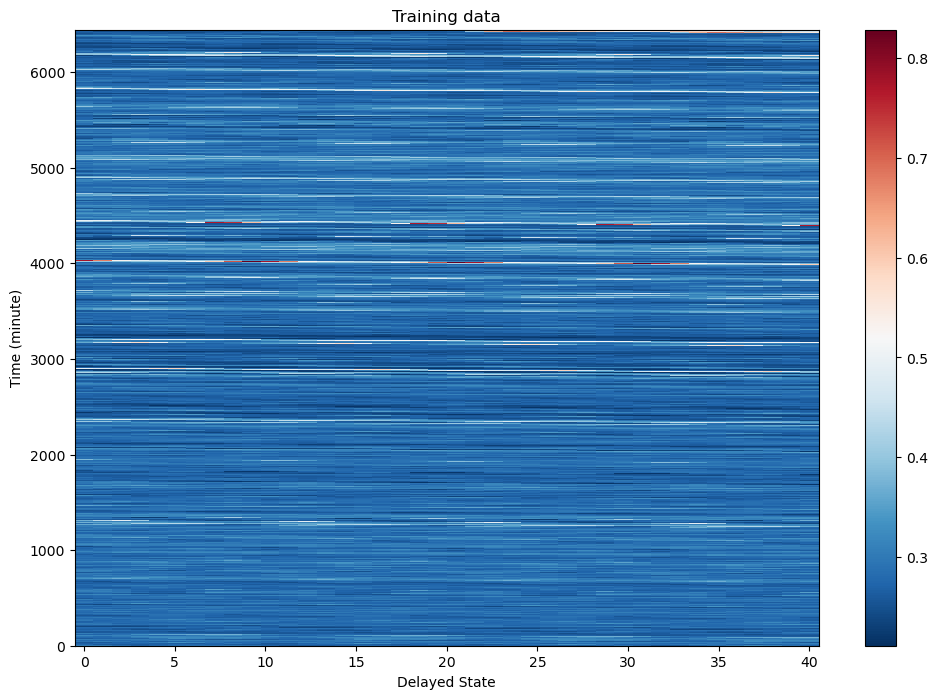

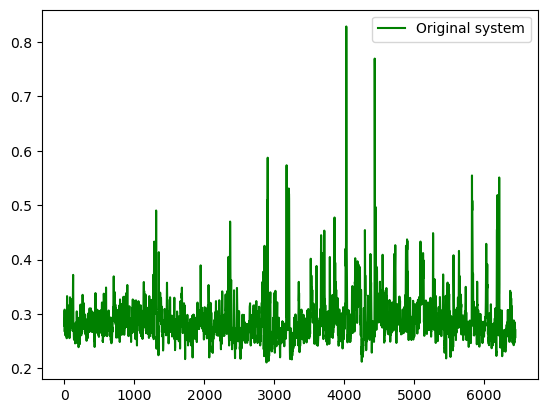

c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 9549206874.122965. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 2528876493763063.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 828457462227825.6. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 937772402224632.2. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\pydmd\snapshots.py:72: U

In [106]:
#DATASET XU_MAT DELLA SRU PARAMETRI: level=0, bin_num=0, offset=0, max_levels=20, max_cycles=10
    
## Scelta del dataset, se a valori complessi o reali
#D_mat = scipy.io.loadmat('real_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('complex_eig_timeseries.mat')
D_mat = scipy.io.loadmat('XU_DMDc.mat')

## Trasformo il formato .mat in un Numpy Array
## Cambiare l'argomento di D_mat['xt'] in D_mat['X'] se si usa il dataset XU_DMDc.mat
D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]
D = np.array(D_mat_list)
U = np.array(U_mat_list)


row_tot = D.shape[0]
column_tot = D.shape[1]


training_mode = 0.9


column_train = int(column_tot * training_mode)

# training mod
D_train = D[:,:int((training_mode*column_tot))]
U_train = U[:,:int(training_mode*column_tot)]

# testing mod
D_test = D[:,D_train.shape[1]:]
U_test = U[:,U_train.shape[1]:]
#for the testing mode we take che rest of array that remain from the division for the training 



x_train = np.linspace(0, row_tot, row_tot)
dt0 = 1    #1 minuto
t_train = np.linspace(0, int(dt0 * column_train), int(dt0 * column_train))

'''
#DATASET TROVATELLO 

# define time and space domains
x = np.linspace(-10, 10, 80)
#t = np.linspace(0, 20, 1600)
t = np.linspace(0, 20, 7160)
Xm,Tm = np.meshgrid(x, t)

# create data
D = exp(-power(Xm/2, 2)) * exp(0.8j * Tm)
D += sin(0.9 * Xm) * exp(1j * Tm)
D += cos(1.1 * Xm) * exp(2j * Tm)
D += 0.6 * sin(1.2 * Xm) * exp(3j * Tm)
D += 0.6 * cos(1.3 * Xm) * exp(4j * Tm)
D += 0.2 * sin(2.0 * Xm) * exp(6j * Tm)
D += 0.2 * cos(2.1 * Xm) * exp(8j * Tm)
D += 0.1 * sin(5.7 * Xm) * exp(10j * Tm)
D += 0.1 * cos(5.9 * Xm) * exp(12j * Tm)
D += 0.1 * np.random.randn(*Xm.shape)
D += 0.03 * np.random.randn(*Xm.shape)
D += 5 * exp(-power((Xm+5)/5, 2)) * exp(-power((Tm-5)/5, 2))
D[:800,40:] += 2
D[200:600,50:70] -= 3
D[800:,:40] -= 2
D[1000:1400,10:30] += 3
D[1000:1080,50:70] += 2
D[1160:1240,50:70] += 2
D[1320:1400,50:70] += 2
D = D.T # Matrice e non vettore

row_tot = D.shape[0]
column_tot = D.shape[1]


training_mode = 0.9


column_train = int(column_tot * training_mode)

# training mod
D_train = D[:,:int((training_mode*column_tot))]
U_train = U[:,:int(training_mode*column_tot)]

# testing mod
D_test = D[:,D_train.shape[1]:]
U_test = U[:,U_train.shape[1]:]
#for the testing mode we take che rest of array that remain from the division for the training 



x_train = np.linspace(0, row_tot, row_tot)
dt0 = 1    #1 minuto
t_train = np.linspace(0, int(dt0 * column_train), int(dt0 * column_train))
'''



def make_plot(X, x=None, y=None, figsize=(12, 8), title='', xlabel='Delayed State', ylabel='Time (minute)', vmin = None, vmax = None, ticks = None):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolormesh(x, y, X, vmin = vmin, vmax = vmax, cmap= "RdBu_r")
    cbar = plt.colorbar(CS)
    if ticks != None:
        plt.xticks(np.arange(0, len(X[0]), ticks))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


make_plot(D_train.T, x=x_train, y=t_train, title = 'Training data')



plt.figure()
plt.plot(t_train, D_train[0,:], 'g', label='Original system')
plt.legend()
plt.show()




#gabriele
def confronto(D, D_mrdmdc_ridimensionata, level):
        D0 = D[0,:]
        D_0 = D_mrdmdc_ridimensionata[0,:]

        t_train = D0.shape[0]
        t_train = np.linspace(0, t_train, t_train)
    
        plt.figure()
        plt.plot(t_train, D0.real, 'b', label='Misura')
        plt.plot(t_train, D_0.real, 'g', label='mrDMDc level: ' + str(level))
        plt.legend()
        plt.show()







def mrdmdc(D, U, level=0, bin_num=0, offset=0, max_levels=20, max_cycles=10):
    """Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding."""
     
    
    # 4 times nyquist limit to capture cycles                 ## per il teorema di nyquist, un segnale sinusoidale puo'
                                                              ## essere ricostruito senza perdere informazioni, fintanto che 
                                                              ## viene campionato ad una frequenza due volte o piu' maggiori
                                                              ## della frequenza massima. (valore tipico: 4 volte maggiori)
                
    nyq = 4 * max_cycles                                      ## nyq = 8 * 2

    

    bin_size = D.shape[1]                          ## bin_size equivale al numero di colonne (1600)


    if (bin_size) < (nyq):                                        ## bin_size(1600)<nyq(16)
        return []

    # extract subsamples 
    step = floor(bin_size / nyq) # max step size to capture cycles   ## floor è una funzione che approssima per difetto
                                                                     ## esempio floor(2.9) equivale a 2.
                                                                     ## in questo caso bin_size / nyq == 100 , quindi step=100
            
    _D = D[:,::(step)]                                           ## D[:,:] è uno slice assignment, in particolare D[:,::step]
                                                             ## considera i valori presi ogni step di tutte le righe e crea
                                                               ## una nuova matrice con solo i valori considerati.
    _U = U[:,::(step)]
    
    D0 = _D[:,:]

    x = D0.shape[0]
    y = D0.shape[1]
    x = np.linspace(0, x, x)
    y = np.linspace(0, y, y)
    #make_plot(D0.T, x=x, y=y, title=" nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))

    U0 = _U[:,1:]   #DA CONTROLLARE SE FARE U[:,:-1]

    dmdc = DMDc(svd_rank=-1) 

    dmdc.level = level            # level of recursion
    dmdc.bin_num = bin_num        # time bin number
    dmdc.bin_size = bin_size      # time bin size
    dmdc.start = offset           # starting index
    dmdc.stop = offset + bin_size # stopping index
    dmdc.step = step              # step size
    dmdc.nyq = nyq


    dmdc.fit(D0,U0)
    

    
    mu = dmdc.eigs
    Phi = dmdc.modes

    '''parte per la filtrazione degli slow'''
    rho = 15 * max_cycles / bin_size                                ## frequenza di taglio rho definita come n° max di modi dinamici
                                                               ## classificati come "slow" diviso il numero di colonne della
                                                               ## matrice D.  2/1600=0.00125

    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho        ## ritorna il valore assoluto [abs()] del logaritmo di mu diviso
                                                               ## 2*pi greco*step, che deve essere minore o uguale a rho.
                                                               ## in questo caso [false false false false true true false]

        
    n = sum(slow) # number of slow modes                       ## il numero dei modi "slow" è dato dalla somma di slow.
                                                               ## in questo caso 2.

    # extract slow modes (perhaps empty)                       ## si estrae i modi "slow"
    mu = mu[slow]                                               ## in mu salva solo gli autovalori "slow"
                                                               ## da 7 autovalori a 2 autovalori.

   
    Phi = Phi[:,slow]                                          ## in phi salva solo i modi dinamici "slow"
                                                               ## phi.shape era (80,7) adesso è (80,2).
    
    if n > 0:                                                  ## se il n° di modi "slow" è maggiore di zero

        
        A = np.linalg.multi_dot(                                                  #A è una matrice 40x40 per livello 0
            [Phi, np.diag(mu), np.linalg.pinv(Phi)]    
        )

        #result = dot(self.dynamics,modes) + _B.dot(self._controlin)

        
        D_dmdc_A = dot(A , D) 
        
        '''
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
        '''
        '''

        #dato = np.array(dato).T



        Prendiamo il codice dell'mrdmd originale per ricavare le dinamiche autonome del sistema
        '''



        # vars for the objective function for D (before subsampling)
        Vand = np.vander(power(mu, 1/step), bin_size, True)   ## vander() restituisce una matrice di Vandermonde, come paramentri
                                                              ## vanno passati: un array 1-D (in questo caso mu elevato a potenza
                                                              ## 1/1600), il numero di colonne dell'uscita e un valore booleano
                                                              ## che indica l'incremento (se True allora le colonne saranno
                                                              ## x^0, x^1, x^2... se False saranno x^(N-1), x^(N-2),...)
                        
        P = multiply(dot(Phi.conj().T, Phi), np.conj(dot(Vand, Vand.conj().T)))  ## multiply() serve per moltiplicare due array.
                                                                                 ## in questo caso tra il [prodotto scalare della
                                                                                 ## la congiunta di phi trasposta e phi] e 
                                                                                 ## [la congiunta del prodotto scalare di Vand
                                                                                 ## e la congiunta di Vand trasposta]
        q = np.conj(diag(dot(dot(Vand, D.conj().T), Phi)))    ##

        # find optimal b solution
        b_opt = solve(P, q).squeeze()                         ## b = P^-1 * q
                                                              ## solve() trova le radici di P risolvendo per q

        # time evolution
        Psi = (Vand.T * b_opt).T                              ## Psi matrice (2,1600)

        B = dmdc.B

        #B = B * step   
        '''in teoria facendo questa moltiplicazione io sto andando a considerare la B '''


    else:

        # zero time evolution
        b_opt = np.array([], dtype='complex')
        Psi = np.zeros([0, bin_size], dtype='complex')
        A = np.zeros([D.shape[0], D.shape[0]], dtype='complex')
        B = np.zeros([dmdc.B.shape[0], dmdc.B.shape[1]], dtype='complex')

    # dmd reconstruction
    #D_dmdc_A = dot(Phi, Psi)                                     ## D_dmd equivale al prodotto scalare tra i modi dinamici slow
    D_dmdc_A = dot(A , D) 
    D_dmdc_B = dot(B, U) 

    dmdc.D_dmdc_A = D_dmdc_A
    dmdc.D_dmdc_B = D_dmdc_B
    
    D_dmdc = D_dmdc_A + D_dmdc_B

    x = D_dmdc.shape[0]
    y = D_dmdc.shape[1]
    x = np.linspace(0, x, x)
    y = np.linspace(0, y, y)
    #make_plot(D_dmdc.T, x=x, y=y, title='levels 0-' + str(level) + " nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))
    #plt.figure()
    #plt.plot(y, D_dmdc_A[0,:], 'b', label='D_dmdc_A')
    #plt.plot(y, D_dmdc_B[0,:], 'g', label='D_dmdc_B')
    #plt.legend()
    #plt.show()

    # remove influence of slow modes
    D = D - D_dmdc                                             ## Rimuove dai dati rimanenti le componenti slow                               



    #node = type('Node', (object,), {})()
   
    dmdc.dato = D_dmdc

    
    dmdc.mu = mu
    dmdc.phi = Phi


    nodes = [dmdc]


    if level < max_levels:
        split = floor(bin_size / 2) # where to split           ## ceil(x) approssima per eccesso x
        nodes += mrdmdc(
            D[:,:split],
            U[:,:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            )
        nodes += mrdmdc(
            D[:,split:],
            U[:,split:],     #aggiunta da alessandro
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            )
    return nodes

nodes = mrdmdc(D_train, U_train)



    



#gabriele
def dimensionamento(dataset, column):

    '''this function allow to plot the graphic of the system during his reconstruction with the dimension of the original system
        an example a matrix 40x4 become 40x7160 
    '''
    # Calcola il fattore di ripetizione per ogni colonna
    fattore_ripetizione = math.ceil(column / dataset.shape[1])    #approssimo per eccesso 
    # Espandi le colonne della matrice
    matrice_finale = np.repeat(dataset, fattore_ripetizione, axis=1)
    # Riduci le colonne al numero desiderato
    matrice_finale = matrice_finale[:, :column]         #qui mi faccio il troncamento
    
    return matrice_finale





#gabriele
def iteration_level(nodes):
    '''this function allow to know the level of iteration that mrdmdc done'''
    level = 0
    for n in nodes:
        if n.level > level:
            level = n.level
    return int(level) 


C:\Users\gabri\AppData\Local\Temp\ipykernel_11120\200803772.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  D_mrdmdc_level_reconstruction = np.hstack(n.dato for n in nodes_level)
c:\Users\gabri\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


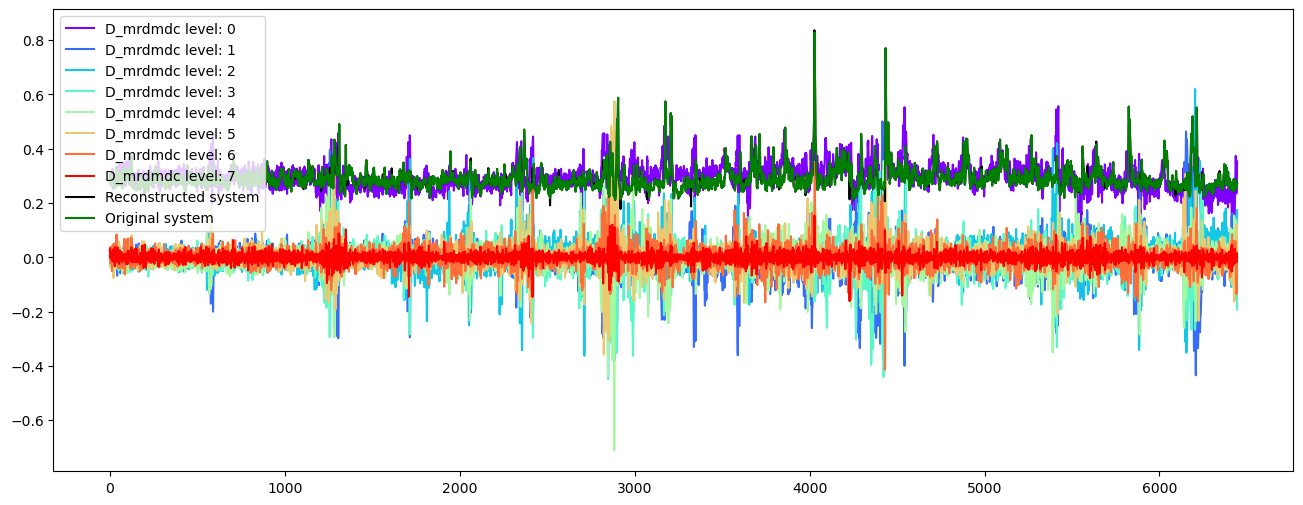

C:\Users\gabri\AppData\Local\Temp\ipykernel_11120\200803772.py:55: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  D_mrdmdc_level_A = np.hstack(n.D_dmdc_A for n in nodes_level)
C:\Users\gabri\AppData\Local\Temp\ipykernel_11120\200803772.py:61: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  D_mrdmdc_level_B = np.hstack(n.D_dmdc_B for n in nodes_level)


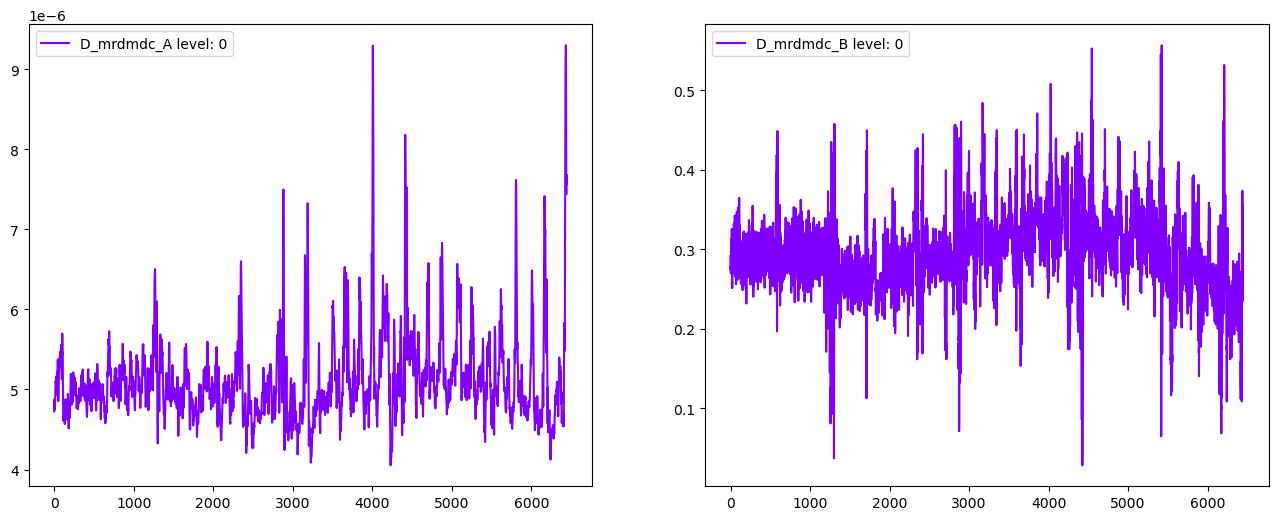

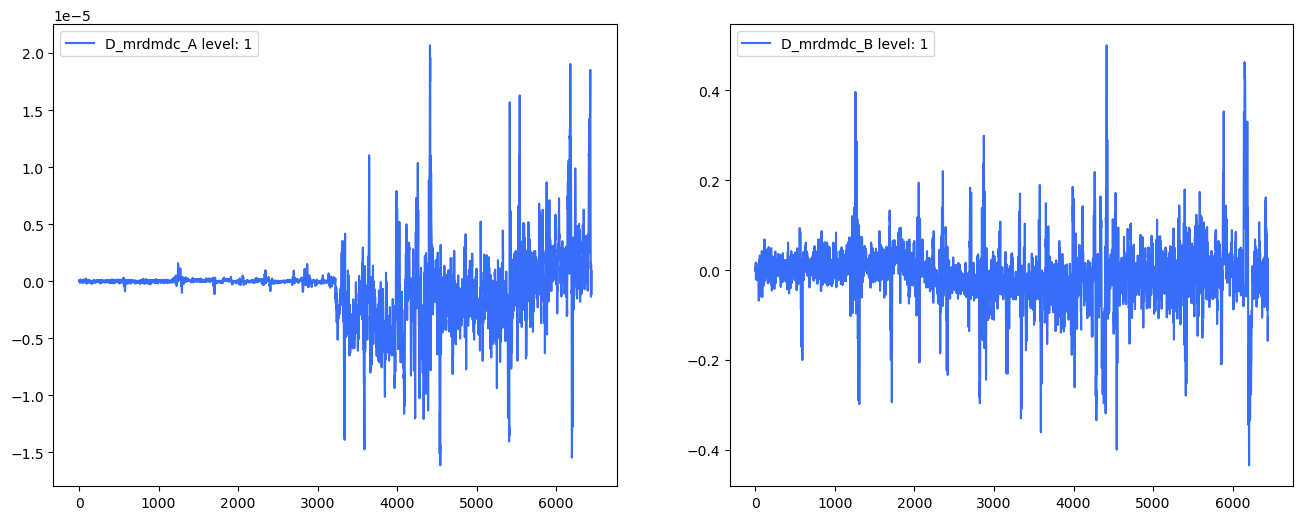

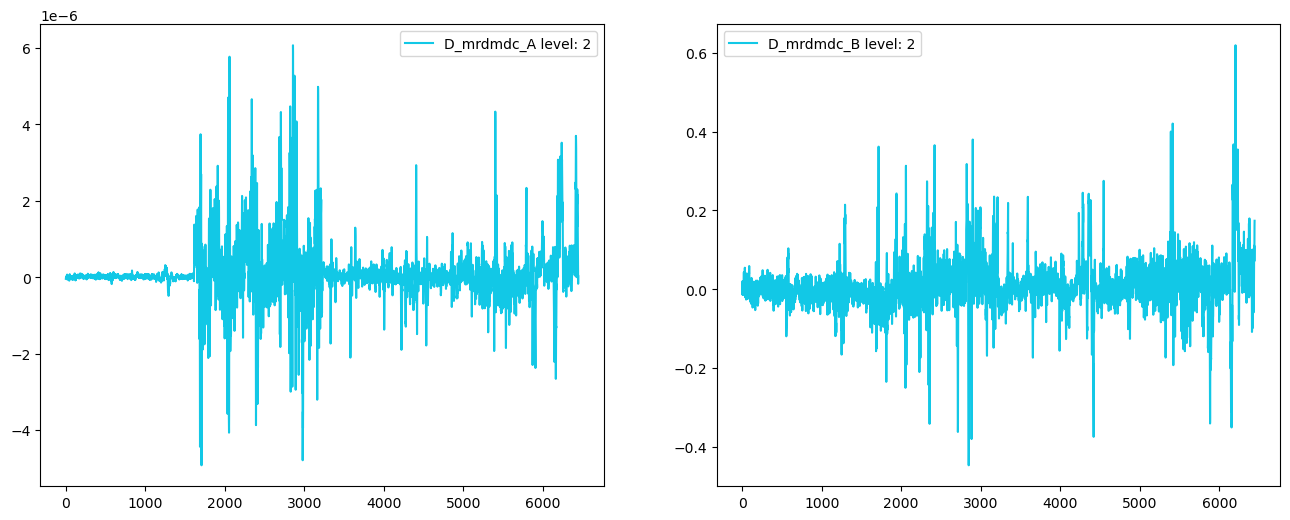

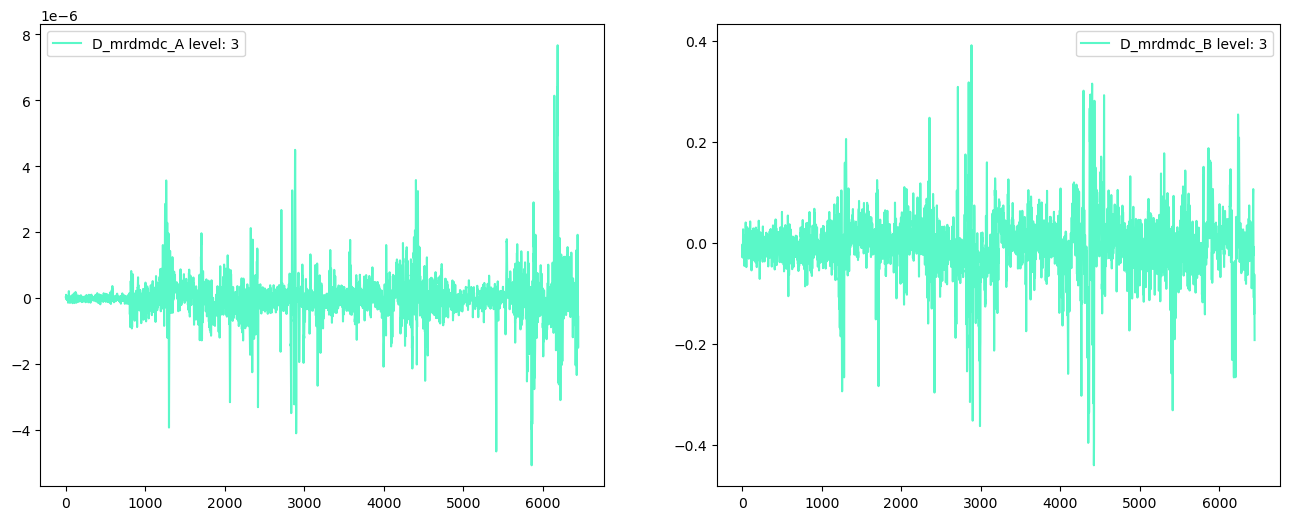

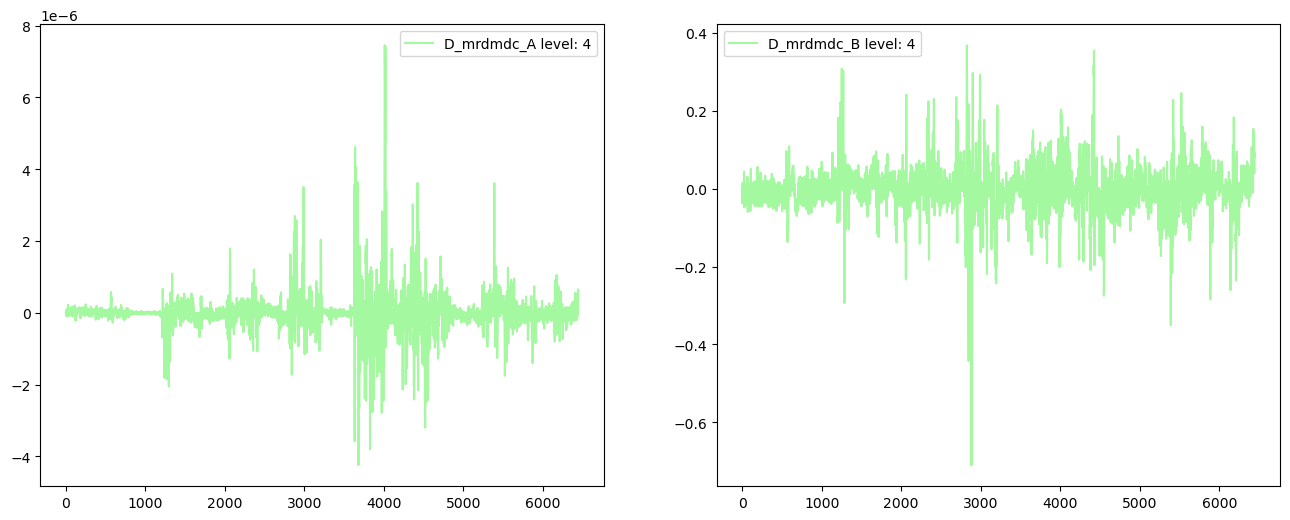

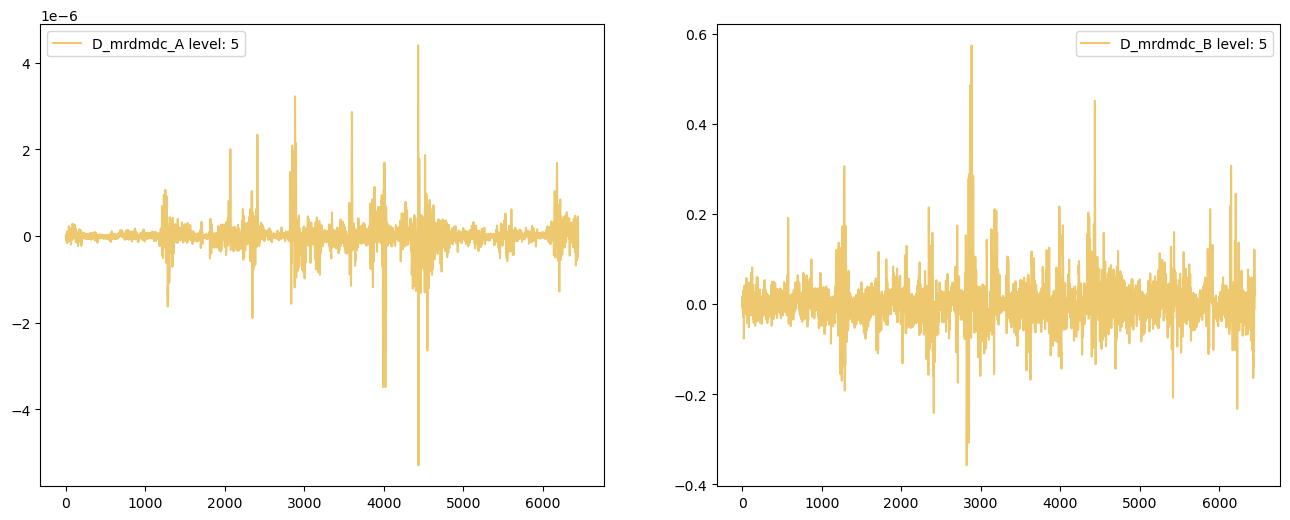

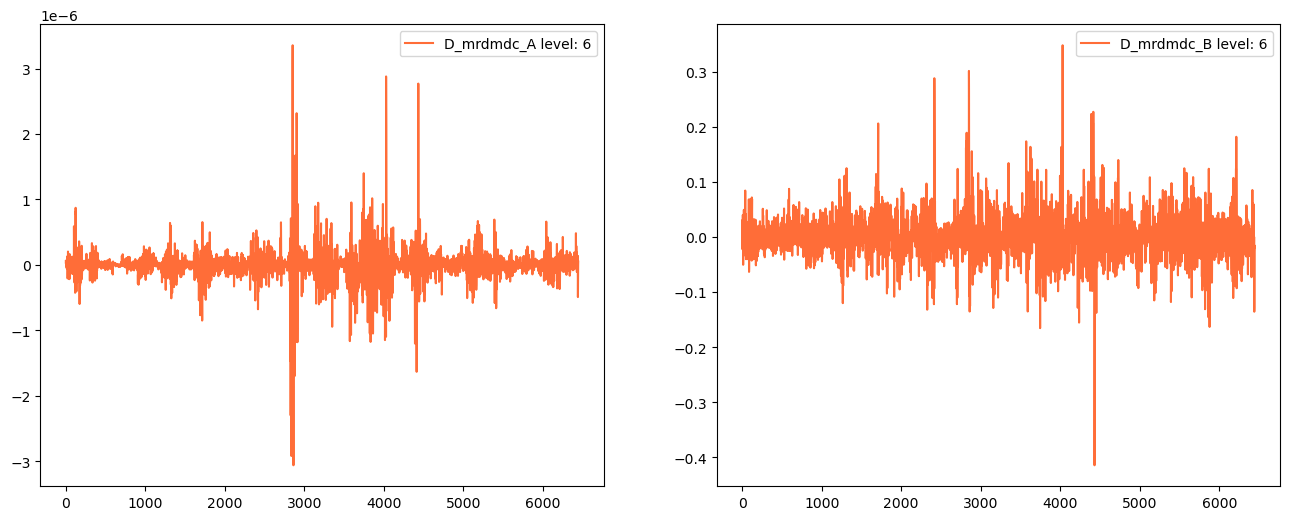

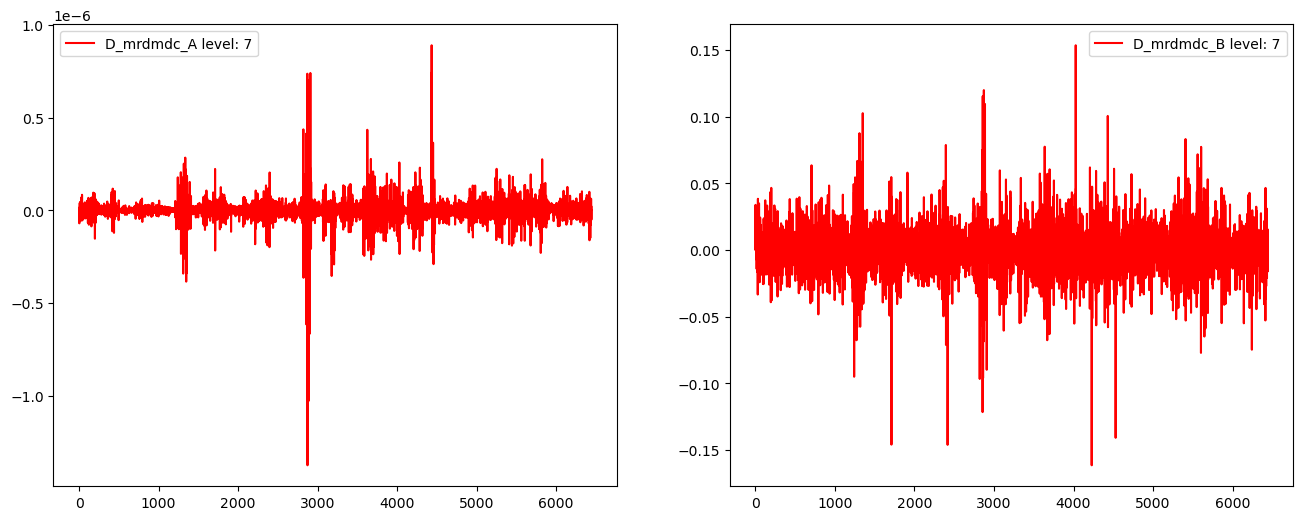

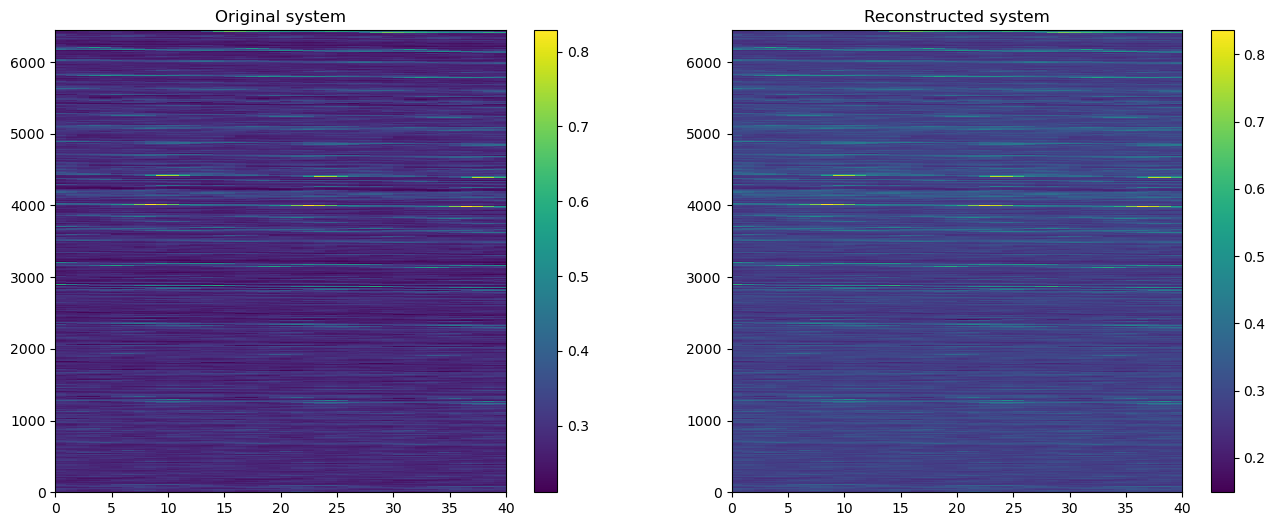

Errore MSE:
5.103370397274771e-06
errore MAPE: 
0.07678196543423424 %
errore MAE: 
0.00022138543625125156
errore RMSE: 
0.0022590640533802424
errore R2: 
0.9971990319814259


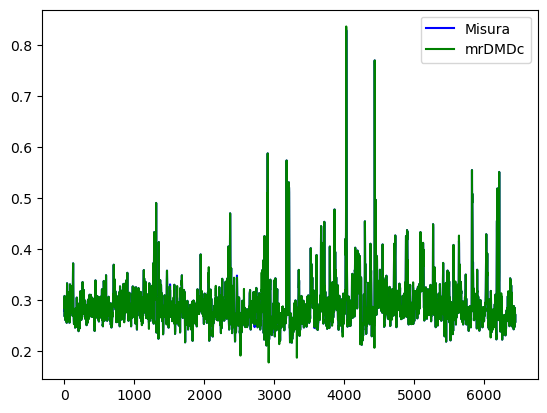

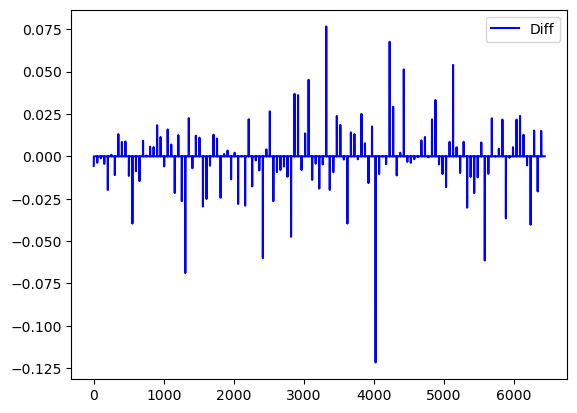

In [107]:



'''
la funzione hstack fa esattamente quello che si vede nell'esempio, i nodi sono messi in "ordine" (se non sbaglio
c'era un possibile dubbio sul cambio di bin-size ogni volta che cambiava livello), perchè vengono presi solamente i nodi 
del livello finale, quindi l'ordine con la quale vengono prelevati è FIFO (cioè i nodi che si trovano con il
livello maggiore in posizione con l'indice minore sono quelli che vengono inseriti prima nella matrice ricostruita)

In questo caso ad esempio con i dati di train vengono inseriti prima il nodo 9 ed il nodo 10, che sono i nodi che hanno il livello
massimo di ricorsione che si trovano con l'indice più piccolo tra i nodi con il livello massimo
'''
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

D_mrdmdc = np.zeros([row_tot, column_train], dtype = complex)   #dichiaro una matrice nulla da riempire 
D_mrdmdc_A = np.zeros([row_tot, column_train], dtype = complex)
D_mrdmdc_B = np.zeros([row_tot, column_train], dtype = complex)

plt.figure(figsize=(16,6))
for level in range(0 , iteration_level(nodes) + 1):

    # extract relevant nodes
    nodes_level = [n for n in nodes if n.level == level]
    nodes_level = sorted(nodes_level, key=lambda n: n.bin_num)

    D_mrdmdc_level_reconstruction = np.hstack(n.dato for n in nodes_level)

    plt.plot(t_train, D_mrdmdc_level_reconstruction[0,:], color=colors[level], label='D_mrdmdc level: ' + str(level))

    #level_rec_ridimensionato = dimensionamento(level_reconstruction, column_train)
    D_mrdmdc += D_mrdmdc_level_reconstruction

    nyq = nodes_level[0].nyq
    step = nodes_level[0].step

    x = D_mrdmdc.shape[0]
    y = D_mrdmdc.shape[1]
    x = np.linspace(0, x, x)
    y = np.linspace(0, y, y)
    #make_plot(D_mrdmdc.T, x=x, y=y, title='levels 0-' + str(level) + " nyq: " + str(nyq) + " step: " + str(step), figsize=(7.5, 5))
    #confronto(D_train, D_mrdmdc, level)

plt.plot(t_train, D_mrdmdc[0,:], 'k', label='Reconstructed system')

plt.plot(t_train, D_train[0,:], 'g', label='Original system')
plt.legend()
plt.show()




colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1)) 

for level in range (0, iteration_level(nodes) + 1):
    nodes_level = [n for n in nodes if n.level == level]
    nodes_level = sorted(nodes_level, key=lambda n: n.bin_num)

    D_mrdmdc_level_A = np.hstack(n.D_dmdc_A for n in nodes_level)
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.plot(t_train, D_mrdmdc_level_A[0,:], color=colors[level], label='D_mrdmdc_A level: ' + str(level))
    plt.legend()

    D_mrdmdc_level_B = np.hstack(n.D_dmdc_B for n in nodes_level)
    plt.subplot(122)
    plt.plot(t_train, D_mrdmdc_level_B[0,:], color=colors[level], label='D_mrdmdc_B level: ' + str(level))
    plt.legend()
    plt.show()
    

    








plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Original system")
plt.pcolor(D_train.real.T)
plt.colorbar()

plt.subplot(122)
plt.title("Reconstructed system")
plt.pcolor(D_mrdmdc.real.T)
plt.colorbar()

plt.show()




def mean_squared_error(y_true, y_pred):
    """
    Funzione che calcola MSE.
    :param y_true: lista di numeri che rappresentano i valori reali
    :param y_pred: lista di numeri che rappresentano i valori predetti
    :restituisce: MSE
    """
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2)

def MAPE (Y_actual,Y_Predicted):   #MEAN ABSOLUTE PERCENTAGE ERROR
    mape = np.mean(np.abs((np.array(Y_actual) - np.array(Y_Predicted))/np.array(Y_actual)))*100
    return mape

def MAE(y_true, y_pred):     #MEAN ABSOLUTE ERROR
    mae_value = np.mean(np.abs(np.array(y_pred) - np.array(y_true)))
    return mae_value

def RMSE(y_true, y_pred):     #ROOT MEAN SQUARED ERROR
    rmse_value = np.sqrt(np.mean((np.array(y_pred) - np.array(y_true))**2))
    return rmse_value

from sklearn.metrics import r2_score
def R2(y_true, y_pred):
    r2_value = r2_score(np.array(y_pred.real), np.array(y_true.real))
    return r2_value


 
print("Errore MSE:")
print((mean_squared_error(D_mrdmdc.real.T,D_train.real.T)))
print ("errore MAPE: ")
print (MAPE(D_mrdmdc.real.T , D_train.real.T),"%")
print ("errore MAE: ")
print(MAE(D_mrdmdc.real.T , D_train.real.T))
print ("errore RMSE: ")
print(RMSE(D_mrdmdc.real.T , D_train.real.T))
print ("errore R2: ")
print(R2(D_mrdmdc.real.T , D_train.real.T))



plt.figure()
plt.plot(t_train, D_train.real[0,:], 'b', label='Misura')
plt.plot(t_train, D_mrdmdc.real[0,:], 'g', label='mrDMDc')
plt.legend()
plt.show()

plt.figure()
error=np.array(D_train) - np.array(D_mrdmdc)
plt.plot(t_train, error.real[0,:], 'b', label='Diff')
plt.legend()
plt.show()







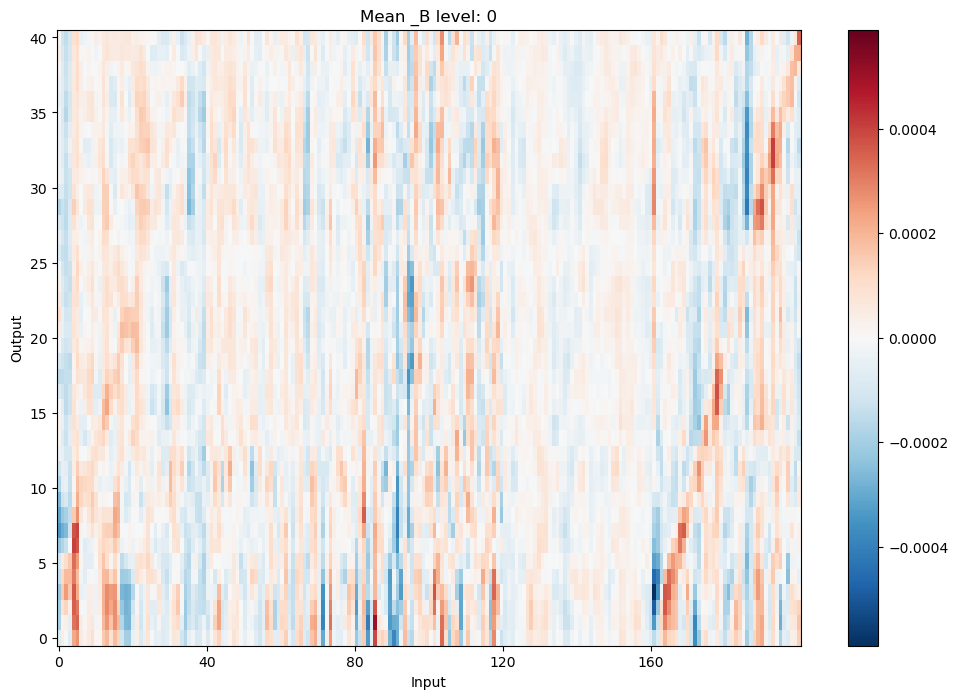

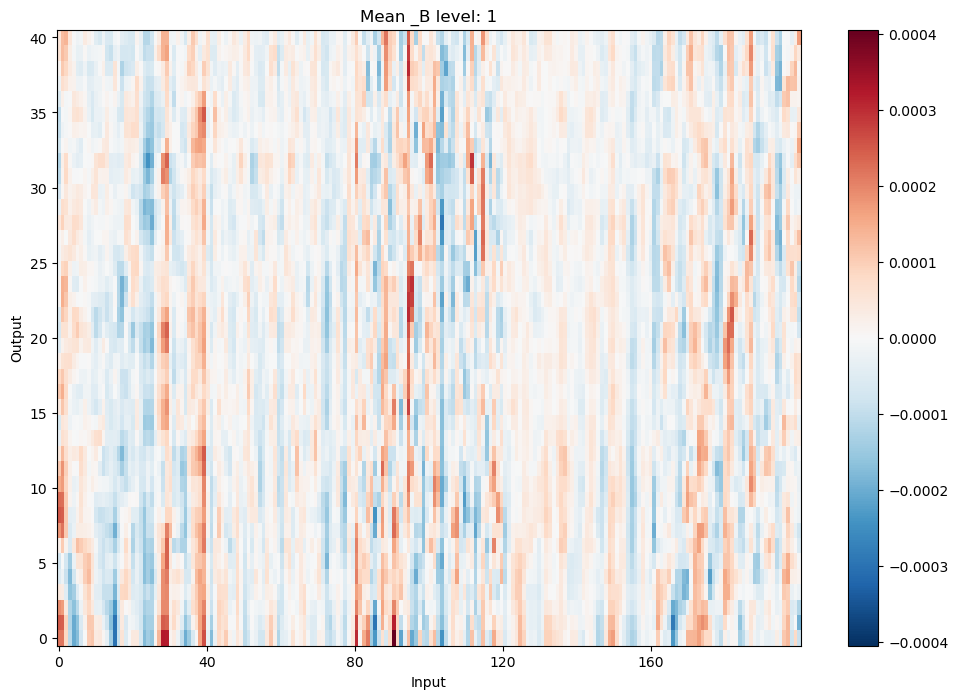

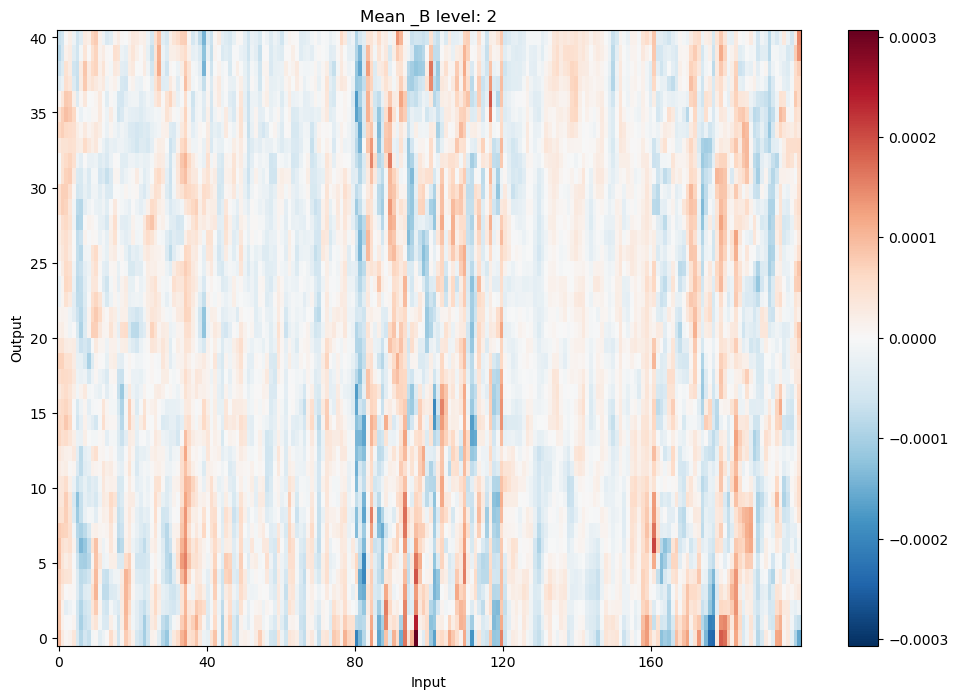

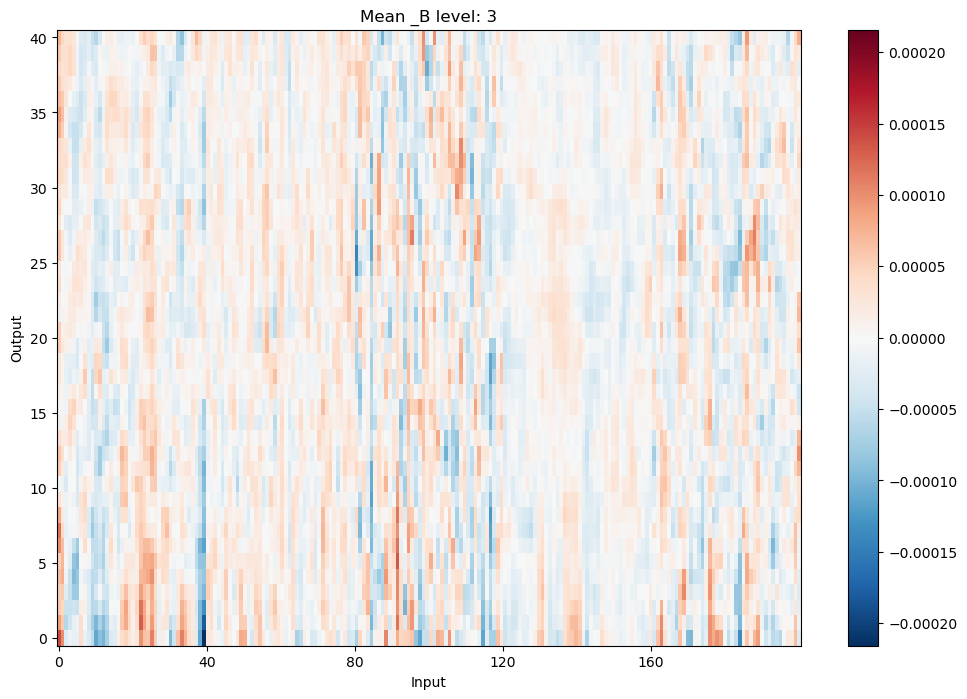

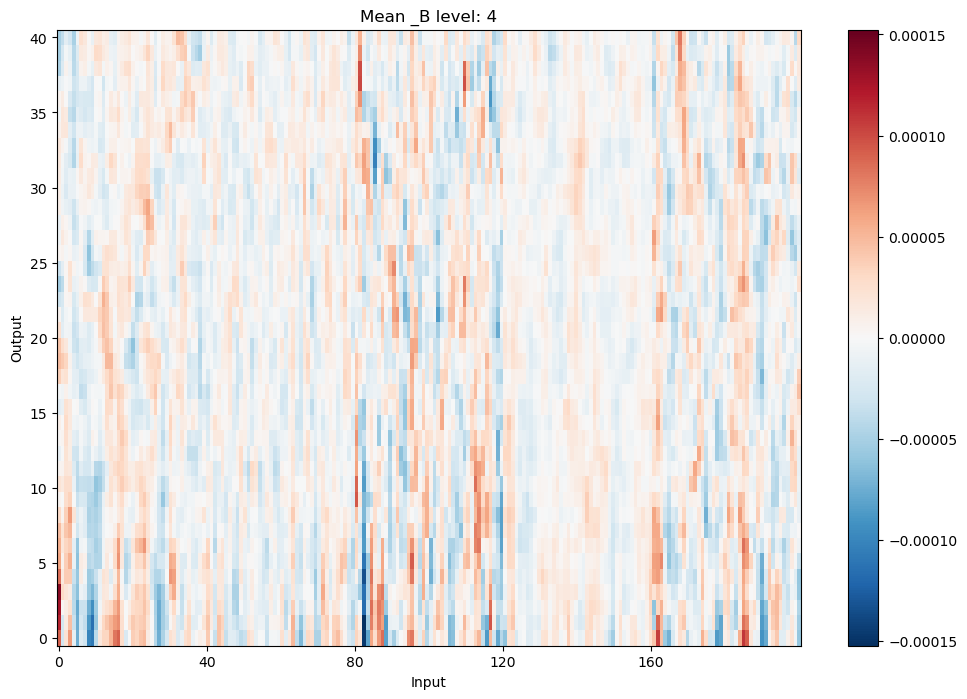

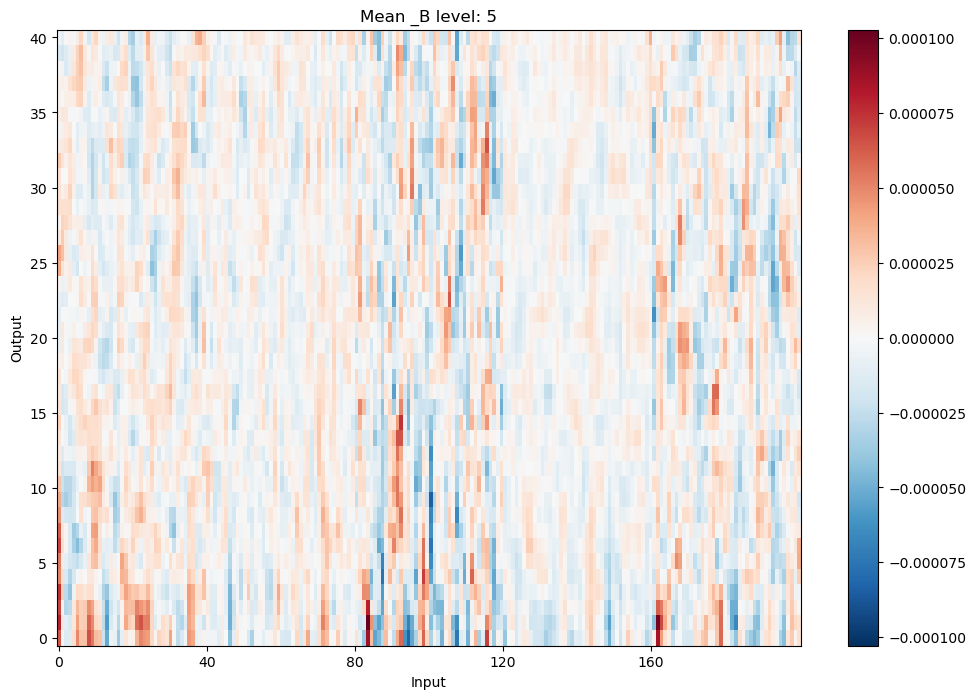

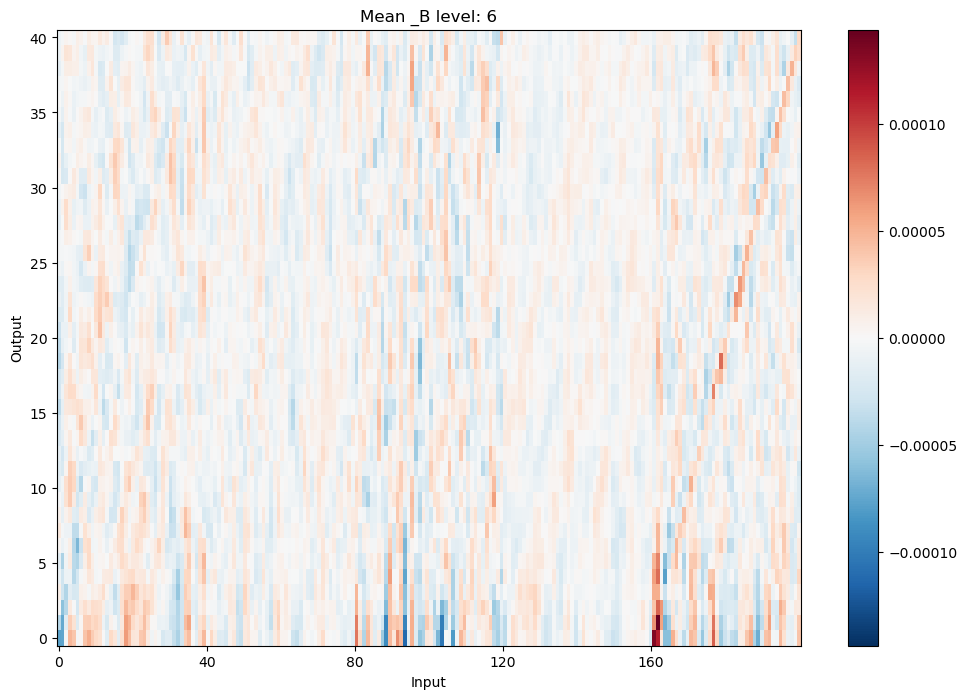

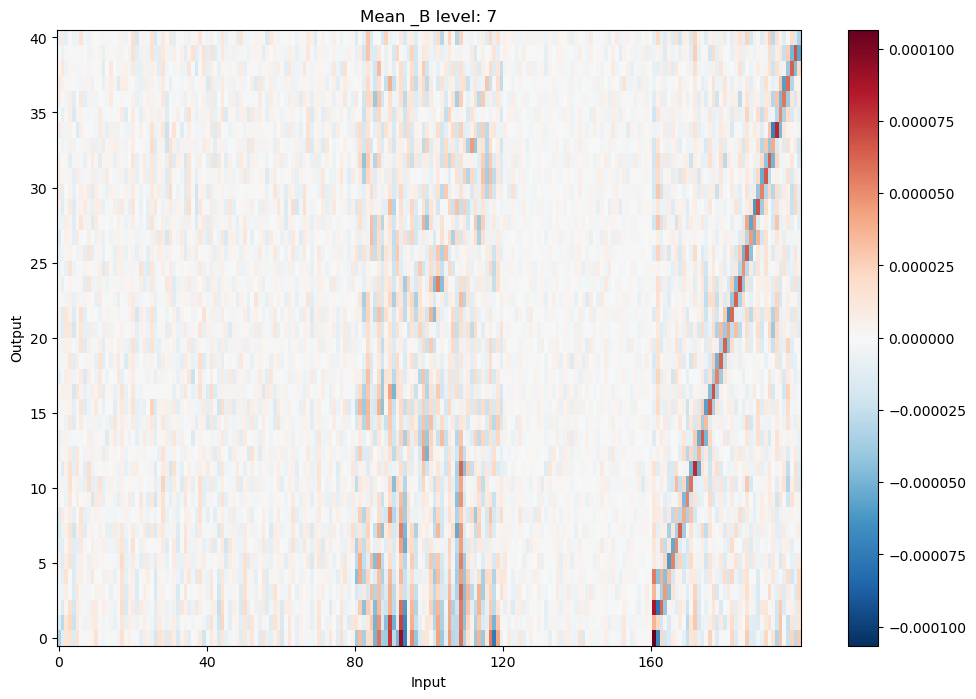

In [108]:

'''
vediamo di mostrare le B e le A_tilde per ogni livello mediate
'''

'''mi faccio restituire il valore massimo di B rispetto a tutti i nodi'''
'''
def max_value(nodes):
    max_value_B = np.max([np.max(node.B) for node in nodes])
    max_value_A_tilde = np.max([np.max(node._Atilde._Atilde) for node in nodes])
    min_value_B = np.min([np.max(node.B) for node in nodes])
    min_value_A_tilde = np.min([np.max(node._Atilde._Atilde) for node in nodes])

    #scelta scala B
    if (max_value_B >= -(min_value_B)):
        scale_B = max_value_B
    else:
        scale_B = -min_value_B

#scelta scala A_tilde
if (max_value_A_tilde >= -(min_value_A_tilde)):
    scale_A_tilde = max_value_A_tilde
else:
    scale_A_tilde = -min_value_A_tilde
'''

def max_value(matrix):
    max_value = np.max([np.max(matrix)])
    min_value = np.min([np.min(matrix)])
    if (max_value >= -(min_value)):
        scale = max_value
    else:
        scale = -min_value
    return scale





for level in range (0, iteration_level(nodes) + 1):
    nodes_level_B = []
    nodes_level_A_tilde = []
    nodes_level_A = []
    for n in nodes:
        if n.level == level:
            nodes_level_B.append(n.B.real)
            nodes_level_A_tilde.append(n._Atilde._Atilde)       #ho messo due volte _Atilde perchè la prima assegnazione è l'oggetto dmdunknownoperator
            nodes_level_A.append(n.A)

    sum_level_B = sum(nodes_level_B)
    mean_level_B = sum_level_B / len(nodes_level_B)
    x = np.linspace(0, mean_level_B.shape[0], mean_level_B.shape[0])
    y = np.linspace(0, mean_level_B.shape[1], mean_level_B.shape[1])
    
    scale_B = max_value(mean_level_B)
    make_plot(mean_level_B, x=y, y=x, title = 'Mean _B level: ' + str(level), xlabel = 'Input', ylabel = 'Output', vmin = -(scale_B), vmax = (scale_B), ticks = 40)    #self.B

    #la parte dell'A_tilde funziona solo se si tronca (cioè svd_rank = 0). con max_cycles uguale a 10 funziona anche con svd_rank=-1 in quanto si tronca a 40 (stati)
    
    '''
    sum_level_A_tilde = sum(nodes_level_A_tilde)
    mean_level_A_tilde = sum_level_A_tilde / len(nodes_level_A_tilde)
    x = np.linspace(0, mean_level_A_tilde.shape[0], mean_level_A_tilde.shape[0])
    y = np.linspace(0, mean_level_A_tilde.shape[1], mean_level_A_tilde.shape[1])

    scale_A_tilde = max_value(mean_level_A_tilde)
    make_plot(mean_level_A_tilde, x=y, y=x, title = 'Mean A_tilde level: ' + str(level), xlabel = 'State', ylabel = 'Output', vmin = -(scale_A_tilde), vmax = (scale_A_tilde))   #self._Atilde
    '''

    '''
    sum_level_A = sum(nodes_level_A)
    mean_level_A = sum_level_A / len(nodes_level_A)
    x = np.linspace(0, mean_level_A.shape[0], mean_level_A.shape[0])
    y = np.linspace(0, mean_level_A.shape[1], mean_level_A.shape[1])

    scale_A = max_value(mean_level_A)
    make_plot(mean_level_A, x=y, y=x, title = 'Mean A level: ' + str(level), xlabel = 'State', ylabel = 'Output', vmin = -(scale_A), vmax = (scale_A))   #self.A
    '''

In [109]:
'''vediamo di mostrare le A_tilde e le B dei nodi'''
for level in range (0, 3):
    count = 0
    for node in nodes:
        if node.level == level:
            x = np.linspace(0, node.B.shape[0], node.B.shape[0])
            y = np.linspace(0, node.B.shape[1], node.B.shape[1])

            scale_B = max_value(node.B)
            #make_plot(node.B, x=y, y=x, title='B level: ' + str(level) + ' Node: ' + str(count), xlabel = 'Input', ylabel = 'Output',  vmin = -(scale_B), vmax = (scale_B))

            x = np.linspace(0, node._Atilde._Atilde.shape[0], node._Atilde._Atilde.shape[0])
            y = np.linspace(0, node._Atilde._Atilde.shape[1], node._Atilde._Atilde.shape[1])

            scale_A_tilde = max_value(node._Atilde._Atilde)
            #make_plot(node._Atilde._Atilde, x=y, y=x, title='A_tilde level: ' + str(level) + ' Node: ' + str(count), xlabel = 'State', ylabel = 'Output', vmin = -(scale_A_tilde), vmax = (scale_A_tilde))
        count = count + 1



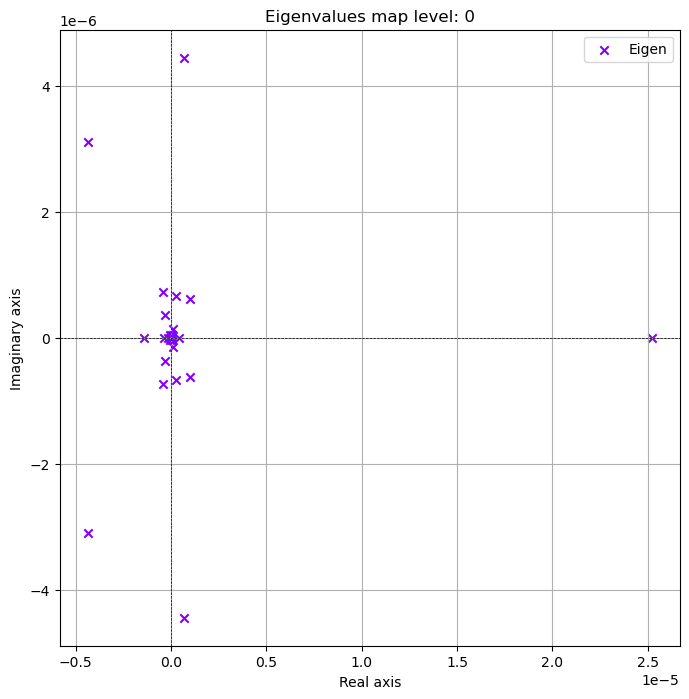

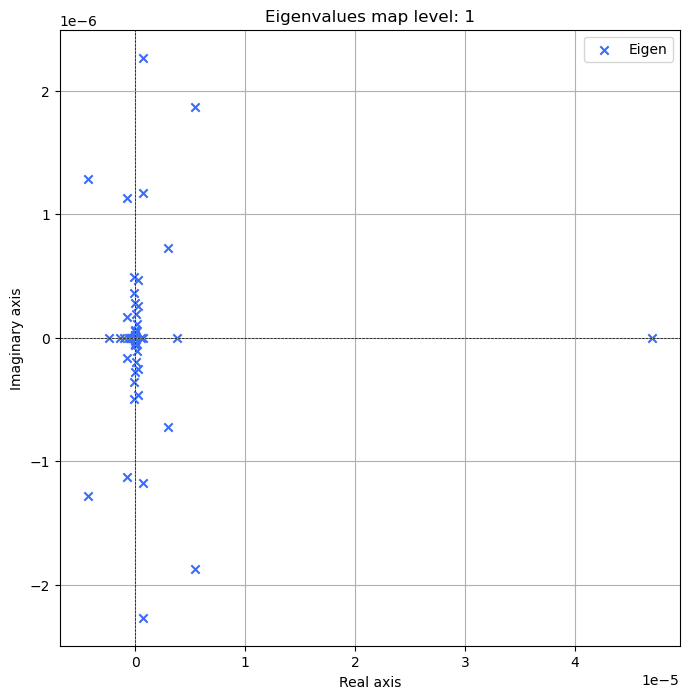

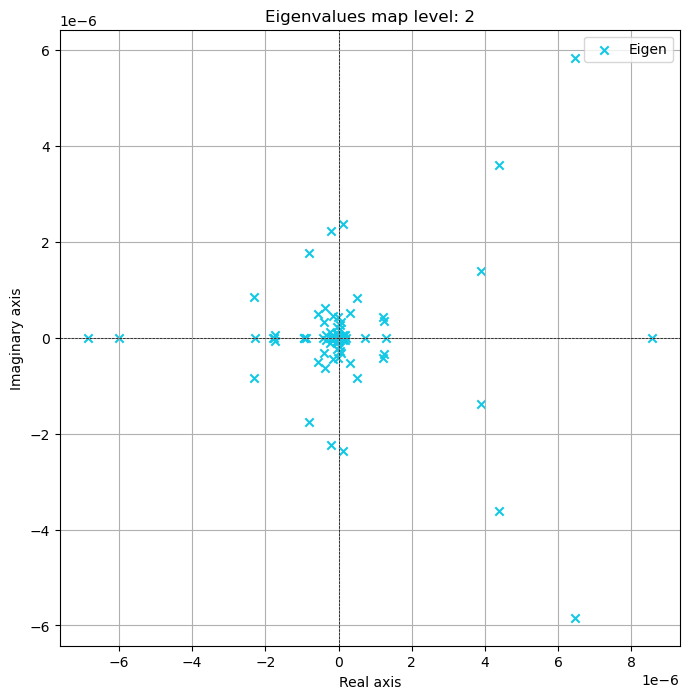

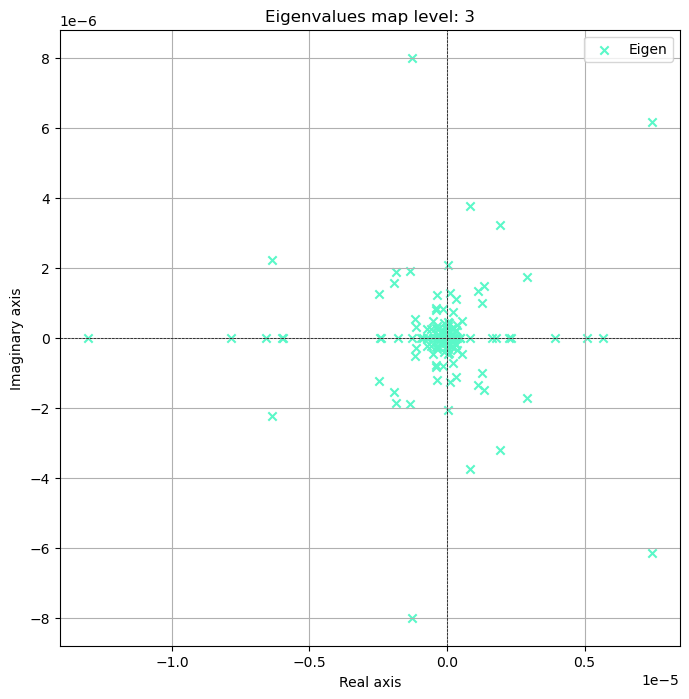

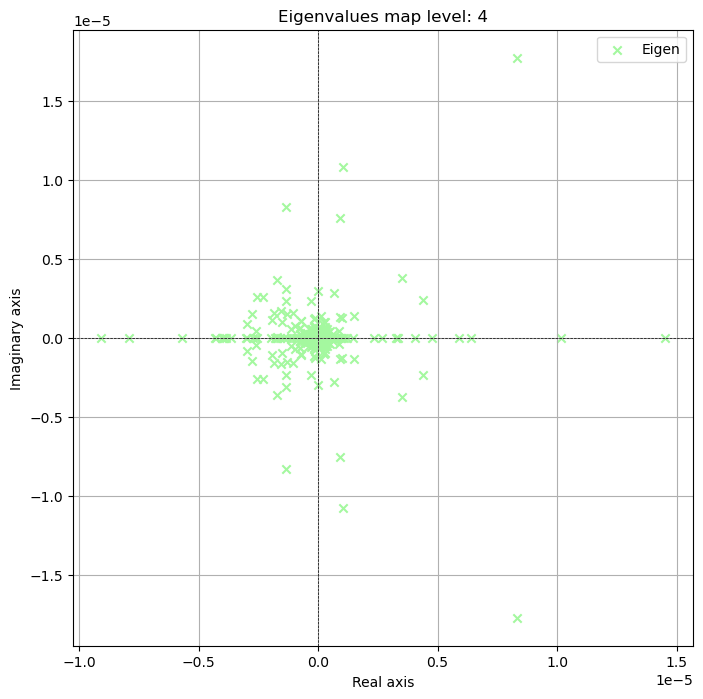

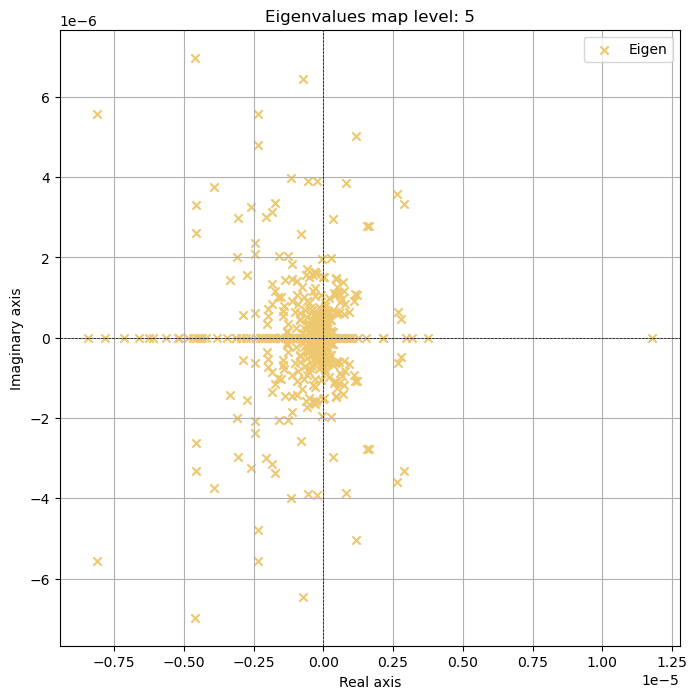

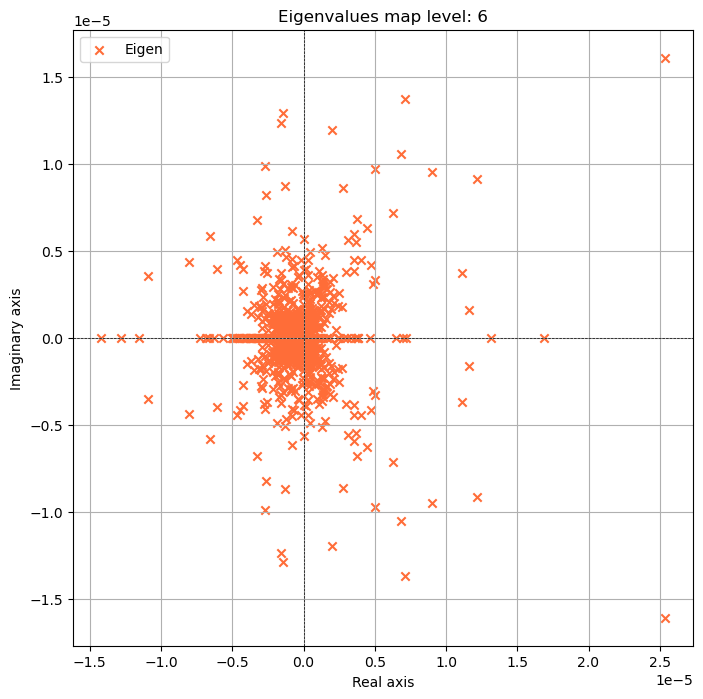

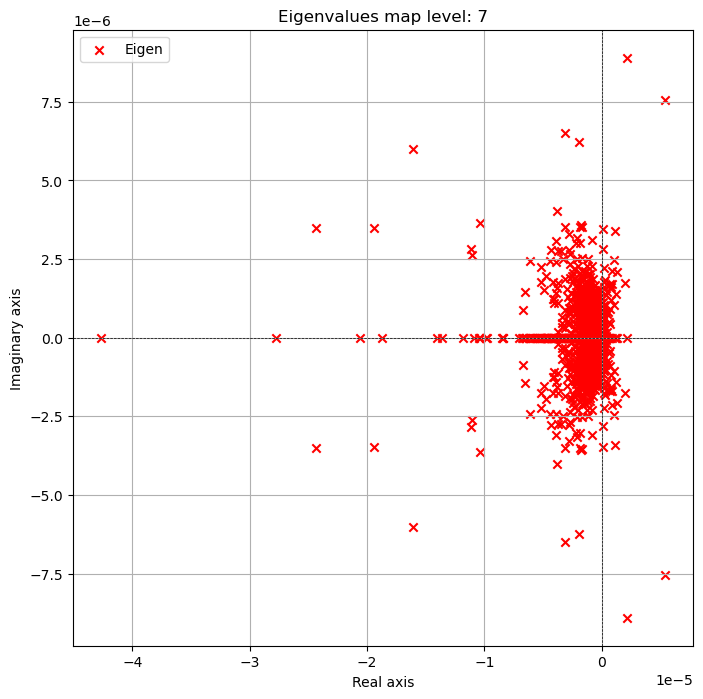

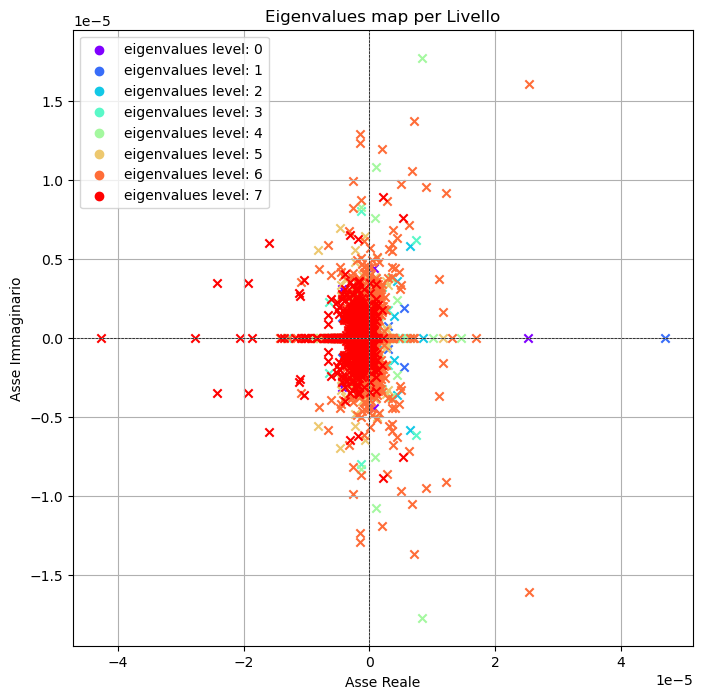

In [110]:
'''andiamo a plottare gli autovalori di ogni livello SENZA LA RIMOZIONE DEGLI SLOW'''
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))
for level in range (0, iteration_level(nodes) + 1):
    eigenvalues = []
    for node in nodes:
        if node.level == level:
            #eigenvalues.extend(node.eigs / ( 2 * pi * node.step))
            eigenvalues.extend(node.eigs)

    real_part = np.real(eigenvalues)
    imag_part = np.imag(eigenvalues)
    # Crea il grafico
    plt.figure(figsize=(8, 8))
    plt.scatter(real_part, imag_part, marker='x', color=colors[level], label='Eigen')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    # Imposta i titoli e la legenda
    plt.title('Eigenvalues map level: ' + str(level))
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend()

    # Mostra il grafico
    plt.grid(True)
    plt.show()






'''plotto il grafico con tutti gli autovalori dei vari livelli con colori diversi SENZA LA RIMOZIONE DEGLI SLOW'''
    
# Crea una lista di colori per ogni livello
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

    # Crea il grafico con tutti gli autovalori
plt.figure(figsize=(8, 8))

for level in range(iteration_level(nodes) + 1):
    plt.scatter([],[], color = colors[level], label = "eigenvalues level: " + str(level))
    for node in nodes:
        if node.level == level:
            #plt.scatter(node.eigs.real / (2* pi * node.step), node.eigs.imag / (2 * pi * node.step), marker='x', color=colors[level])
            plt.scatter(node.eigs.real, node.eigs.imag, marker='x', color=colors[level])


plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    # Imposta i titoli e la legenda
plt.title('Eigenvalues map per Livello')
plt.xlabel('Asse Reale')
plt.ylabel('Asse Immaginario')
plt.legend()

    # Mostra il grafico
plt.grid(True)
plt.show()


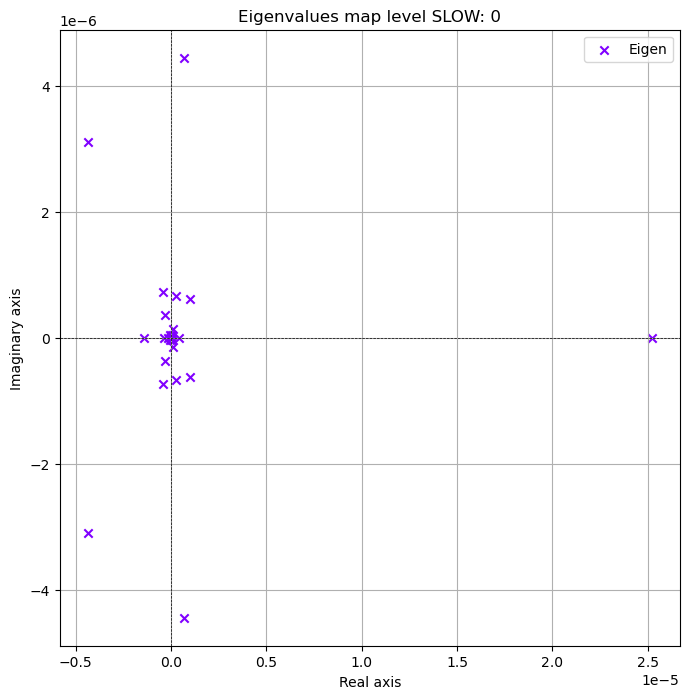

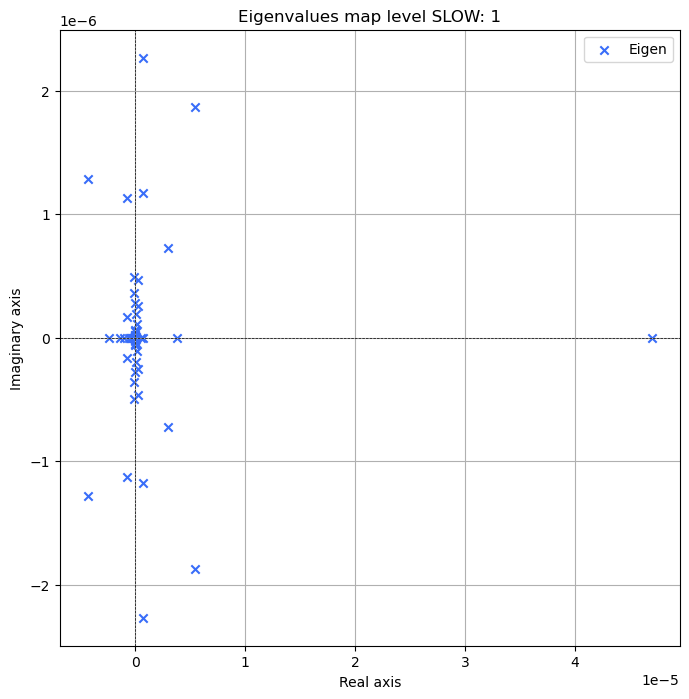

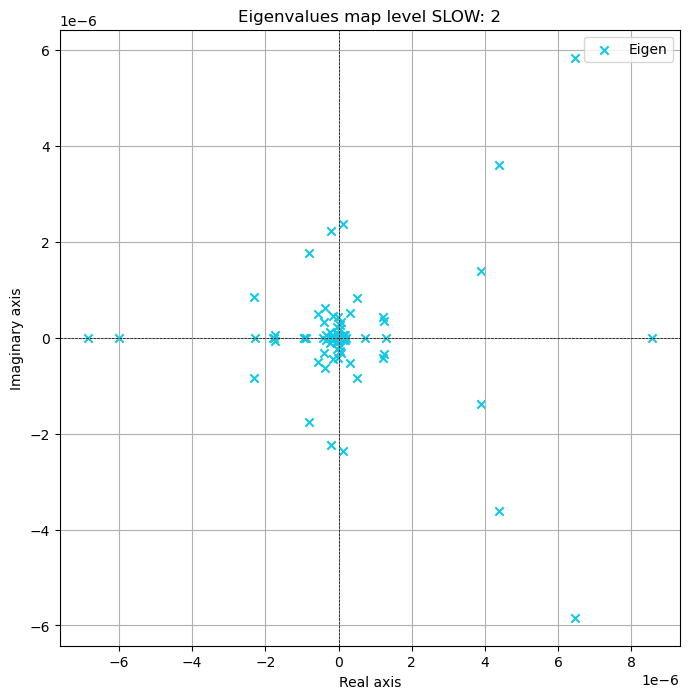

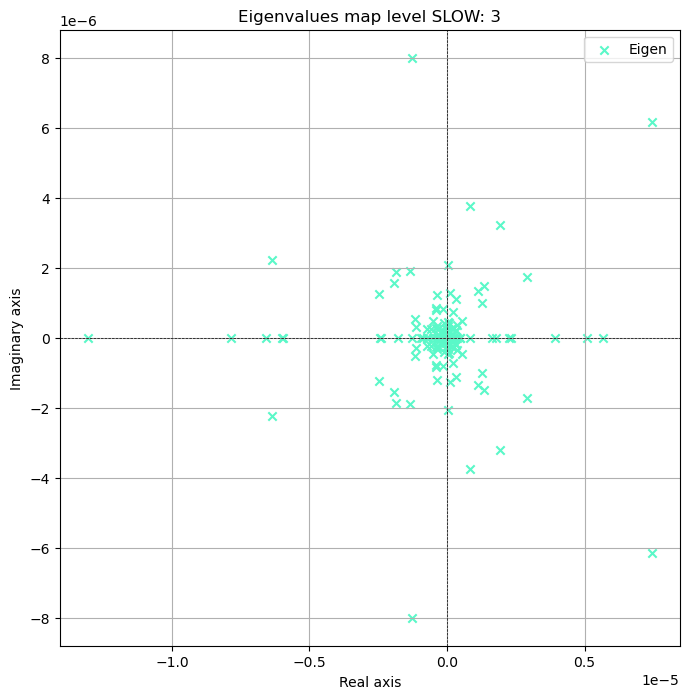

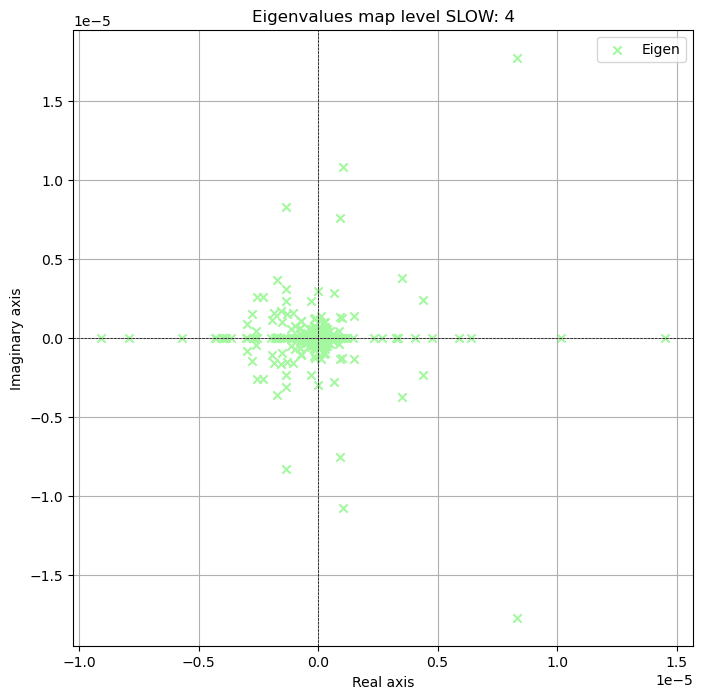

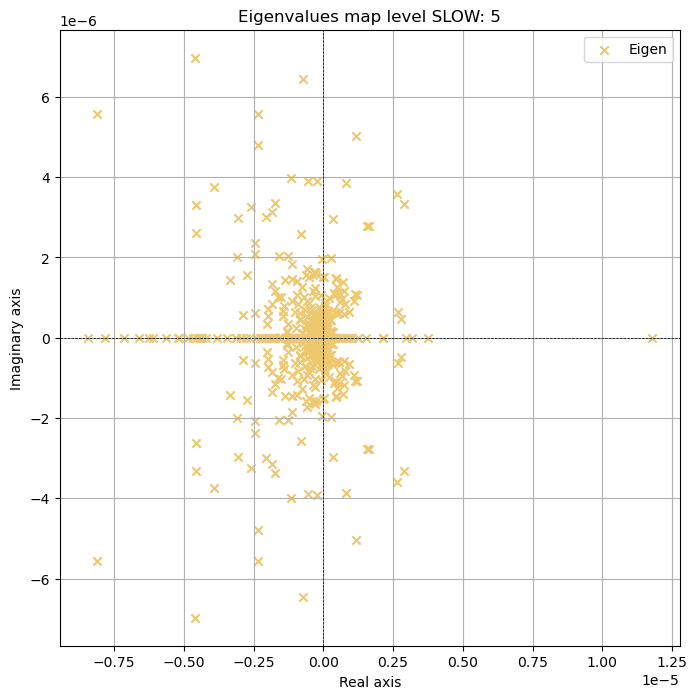

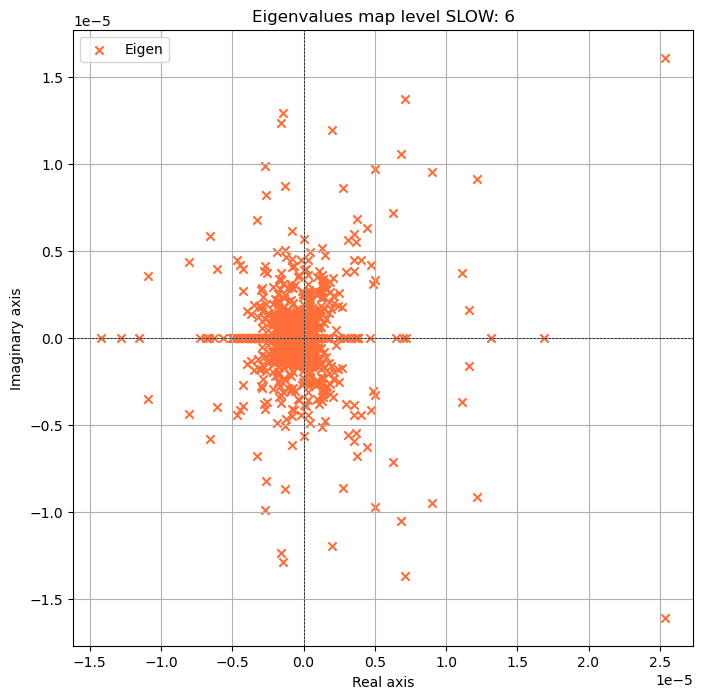

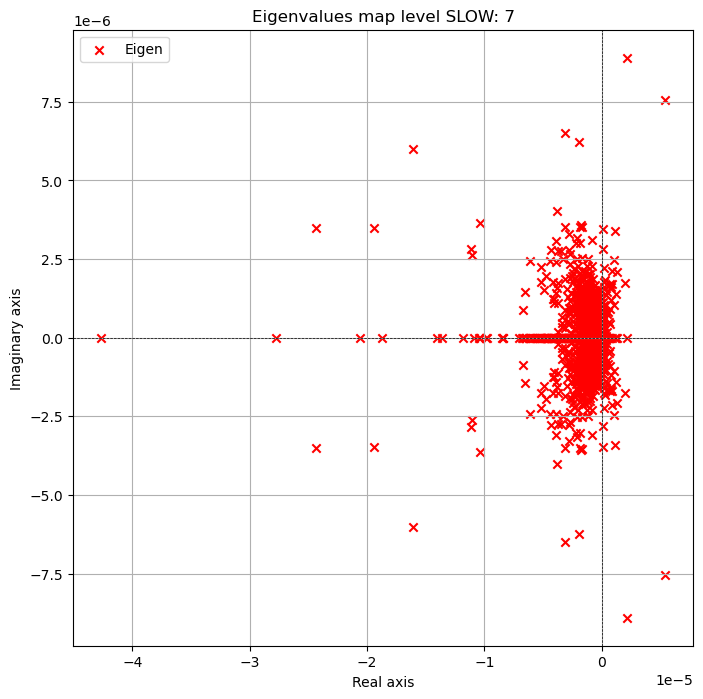

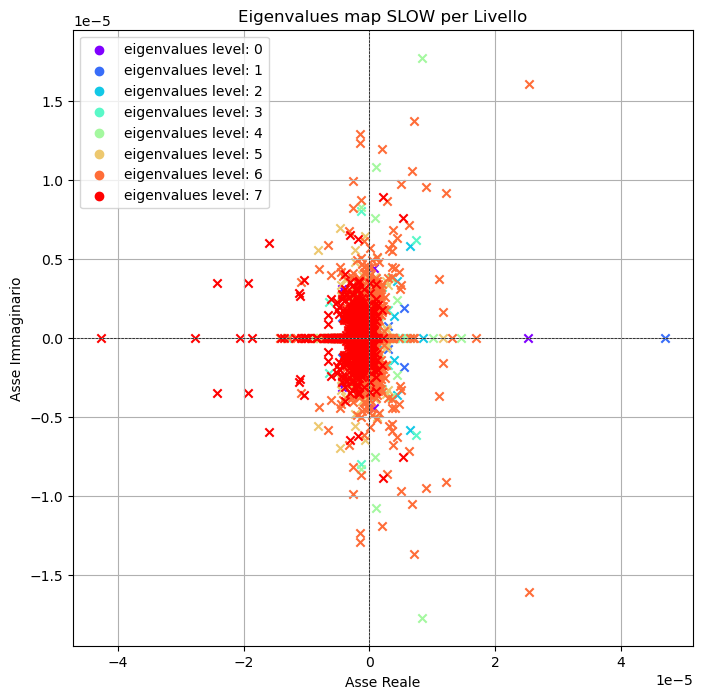

In [111]:


'''andiamo a plottare gli autovalori di ogni livello CON LA RIMOZIONE DEGLI SLOW'''
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))
for level in range (0, iteration_level(nodes) + 1):
    eigenvalues = []
    for node in nodes:
        if node.level == level:
            #eigenvalues.extend(node.eigs / ( 2 * pi * node.step))
            eigenvalues.extend(node.mu)

    real_part = np.real(eigenvalues)
    imag_part = np.imag(eigenvalues)
    # Crea il grafico
    plt.figure(figsize=(8, 8))
    plt.scatter(real_part, imag_part, marker='x', color=colors[level], label='Eigen')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    # Imposta i titoli e la legenda
    plt.title('Eigenvalues map level SLOW: ' + str(level))
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend()

    # Mostra il grafico
    plt.grid(True)
    plt.show()






'''plotto il grafico con tutti gli autovalori dei vari livelli con colori diversi CON LA RIMOZIONE DEGLI SLOW'''
    
# Crea una lista di colori per ogni livello
colors = plt.cm.rainbow(np.linspace(0, 1, iteration_level(nodes) + 1))

    # Crea il grafico con tutti gli autovalori
plt.figure(figsize=(8, 8))

for level in range(iteration_level(nodes) + 1):
    plt.scatter([],[], color = colors[level], label = "eigenvalues level: " + str(level))
    for node in nodes:
        if node.level == level:
            #plt.scatter(node.eigs.real / (2* pi * node.step), node.eigs.imag / (2 * pi * node.step), marker='x', color=colors[level])
            plt.scatter(node.mu.real, node.mu.imag, marker='x', color=colors[level])


plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    # Imposta i titoli e la legenda
plt.title('Eigenvalues map SLOW per Livello')
plt.xlabel('Asse Reale')
plt.ylabel('Asse Immaginario')
plt.legend()

    # Mostra il grafico
plt.grid(True)
plt.show()




In [112]:

'''#Facciamo una funzione per controllare qual è il bin_size più vicino alla U_test

def choose_bin(U_test, nodes):
    for i in range(0, len(nodes)):
        if (nodes[i].bin_size >= U_test.shape[1]):
            node = nodes[i]
    return node

#A questo punto vado a campionare la U_test e la passo a reconstructed_data

dmdc_reconstruct = choose_bin(U_test, nodes)
U_test = dimensionamento(U_test, dmdc_reconstruct.bin_size)
U_test_sub = U_test[:,::dmdc_reconstruct.step]

nodes_reconstruct = []
for node in nodes:
    if node.level == dmdc_reconstruct.level:
        nodes_reconstruct.append(node)

#rec = np.zeros([row_tot, column_train], dtype = complex)
insieme_reconstruct = []

for node in nodes_reconstruct:
    reconstructed_data_test = node.reconstructed_data(U_test_sub[:,1:])
    insieme_reconstruct.append(reconstructed_data_test)      #append function add the data passed to array

reconstruct = np.hstack(insieme_reconstruct)

#reconstruct = dimensionamento(reconstruct, column_train)
x = reconstruct.shape[0]
y = reconstruct.shape[1]   
x = np.linspace(0, x, x)
y = np.linspace(0, y, y)
make_plot(reconstruct.T, x=x, y=y, title='levels 0-' + str(i), figsize=(7.5, 5))
confronto(D_train, reconstruct)

'''



"#Facciamo una funzione per controllare qual è il bin_size più vicino alla U_test\n\ndef choose_bin(U_test, nodes):\n    for i in range(0, len(nodes)):\n        if (nodes[i].bin_size >= U_test.shape[1]):\n            node = nodes[i]\n    return node\n\n#A questo punto vado a campionare la U_test e la passo a reconstructed_data\n\ndmdc_reconstruct = choose_bin(U_test, nodes)\nU_test = dimensionamento(U_test, dmdc_reconstruct.bin_size)\nU_test_sub = U_test[:,::dmdc_reconstruct.step]\n\nnodes_reconstruct = []\nfor node in nodes:\n    if node.level == dmdc_reconstruct.level:\n        nodes_reconstruct.append(node)\n\n#rec = np.zeros([row_tot, column_train], dtype = complex)\ninsieme_reconstruct = []\n\nfor node in nodes_reconstruct:\n    reconstructed_data_test = node.reconstructed_data(U_test_sub[:,1:])\n    insieme_reconstruct.append(reconstructed_data_test)      #append function add the data passed to array\n\nreconstruct = np.hstack(insieme_reconstruct)\n\n#reconstruct = dimensionament